# Importing Libraries

In [3]:
import os
import torch
import random
import pickle
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
seed = 42 # Set a fixed seed for reproducibility
random.seed(seed) # Python's built-in random module
np.random.seed(seed) # NumPy
torch.manual_seed(seed) # PyTorch
torch.cuda.manual_seed(seed) # If using CUDA
torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# # Ensure deterministic behavior (can slow down performance)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Loading Dataset

In [6]:
# Define transformation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])


def load_cifar10(transform, root='./data', train=True):
    return datasets.CIFAR10(root=root, train=train, download=True, transform=transform)

def split_dataset(dataset, train_ratio=0.8): # Split dataset into training and testing subsets
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    test_size = dataset_size - train_size

    train_indices = list(range(train_size))
    test_indices = list(range(train_size, dataset_size))

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, test_dataset

def subset_to_numpy(dataset, subset): # Convert Subsets to numpy arrays
    images = dataset.data[subset.indices]
    labels = np.array(dataset.targets)[subset.indices]
    return images, labels

CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
cifar10_dataset = load_cifar10(transform=transform)
train_dataset, test_dataset = split_dataset(cifar10_dataset)

train_images, train_labels = subset_to_numpy(cifar10_dataset, train_dataset)
test_images, test_labels = subset_to_numpy(cifar10_dataset, test_dataset)

print(f"Dataset size: {len(cifar10_dataset)}")
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

# Optionally create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 91921460.29it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Dataset size: 50000
Train images shape: (40000, 32, 32, 3), Train labels shape: (40000,)
Test images shape: (10000, 32, 32, 3), Test labels shape: (10000,)


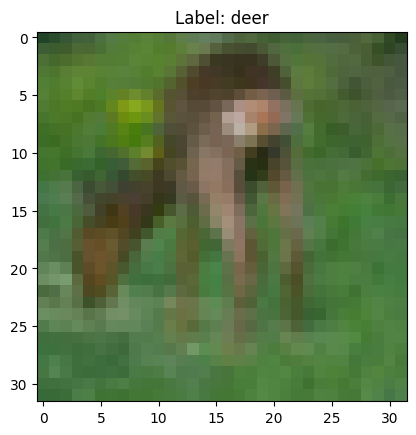

In [8]:
idx = 6
image = test_images[idx]
label = test_labels[idx]
name_label = CLASSES[label]
plt.imshow(image)
plt.title(f"Label: {name_label}")
plt.show()

# Partitioning Dataset

In [9]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32, seed=42):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]

        # Set the seed again before generating proportions for this class
        np.random.seed(seed + c)  # Adding `c` ensures unique seeds for each class
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]

        # Set the seed again before generating proportions for this class
        np.random.seed(seed + c + 1000)  # Adding an offset ensures unique seeds for test data
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        # client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)

        if len(train_data.shape) == 3:  # Grayscale
            client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        else:  # RGB
            client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to [N, C, H, W]

        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=True, drop_last=False)
        federated_train_loaders.append(train_loader)

        # client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        if len(test_data.shape) == 3:  # Grayscale
            client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        else:  # RGB
            client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to [N, C, H, W]
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


#Setting up Model

In [10]:
class SimpleCNN(nn.Module): #this is same as TINY VGG model
    def __init__(self, filters=64, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Block 1
        self.conv_1_1 = nn.Conv2d(3, filters, kernel_size=3, padding=1)  # Input: 3x32x32 -> Output: filters x 32 x 32
        self.relu_1_1 = nn.ReLU()
        self.conv_1_2 = nn.Conv2d(filters, filters, kernel_size=3, padding=1)  # Output: filters x 32 x 32
        self.relu_1_2 = nn.ReLU()
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: filters x 16 x 16

        # Block 2
        self.conv_2_1 = nn.Conv2d(filters, filters * 2, kernel_size=3, padding=1)  # Output: filters*2 x 16 x 16
        self.relu_2_1 = nn.ReLU()
        self.conv_2_2 = nn.Conv2d(filters * 2, filters * 2, kernel_size=3, padding=1)  # Output: filters*2 x 16 x 16
        self.relu_2_2 = nn.ReLU()
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: filters*2 x 8 x 8

        # Block 3
        self.conv_3_1 = nn.Conv2d(filters * 2, filters * 4, kernel_size=3, padding=1)  # Output: filters*4 x 8 x 8
        self.relu_3_1 = nn.ReLU()
        self.conv_3_2 = nn.Conv2d(filters * 4, filters * 4, kernel_size=3, padding=1)  # Output: filters*4 x 8 x 8
        self.relu_3_2 = nn.ReLU()
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: filters*4 x 4 x 4

        # Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(filters * 4 * 4 * 4, num_classes)  # Output: 10 classes (CIFAR-10)

    def forward(self, x):
        # Block 1
        x = self.relu_1_1(self.conv_1_1(x))
        x = self.relu_1_2(self.conv_1_2(x))
        x = self.max_pool_1(x)

        # Block 2
        x = self.relu_2_1(self.conv_2_1(x))
        x = self.relu_2_2(self.conv_2_2(x))
        x = self.max_pool_2(x)

        # Block 3
        x = self.relu_3_1(self.conv_3_1(x))
        x = self.relu_3_2(self.conv_3_2(x))
        x = self.max_pool_3(x)

        # Flatten and Fully Connected Layer
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def get_latents(self, x):
        # Extract feature latents before the final fully connected layer
        x = self.relu_1_1(self.conv_1_1(x))
        x = self.relu_1_2(self.conv_1_2(x))
        x = self.max_pool_1(x)

        x = self.relu_2_1(self.conv_2_1(x))
        x = self.relu_2_2(self.conv_2_2(x))
        x = self.max_pool_2(x)

        x = self.relu_3_1(self.conv_3_1(x))
        x = self.relu_3_2(self.conv_3_2(x))
        x = self.max_pool_3(x)

        x = self.flatten(x)
        latents = x  # Latent features before the final output layer
        return latents

model = SimpleCNN().to(device)
summary(model, (3, 32, 32))  # Pass input shape (channels, height, width) instead of the tensor

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

# FED AVERAGE

In [93]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy

In [94]:
# Server-side Federated Averaging
def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    global_model = global_model.to(device)

    for r in tqdm(range(rounds), desc="Communication Rounds", leave=True):
        client_updates = []

        # Distribute model and collect client updates
        for i in tqdm(range(num_clients), desc=f"Clients Training (Round {r+1})", leave=False):
            # print(f"Training on Client {i + 1}")
            update = local_train(global_model, train_loaders[i], epochs, lr)
            # update = local_train(global_model, train_loaders, epochs, lr)
            client_updates.append(update)

        # Average updates
        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in global_model.state_dict().keys()}

        # Apply averaged updates to global model
        for name, param in global_model.state_dict().items():
            param.add_(avg_update[name])  # Update the global model in-place

        round_avg_updates.append(avg_update)

        # Evaluate the global model
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = global_model(data)
                    _, predicted = outputs.max(1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        accuracy = correct / total
        round_accuracies.append(accuracy)
        tqdm.write(f"Round {r+1} Accuracy: {accuracy:.4f}")

    return round_avg_updates, round_accuracies


# Client-side local training
def local_train(model, train_loader, epochs, lr):
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)

    # for epoch in tqdm(range(epochs), desc="Local Training", leave=False):
    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels  = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = local_model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    return overall_update

In [16]:
def local_train_with_ridge(model, train_loader, epochs, lr, lambda_reg):
    """
    Trains a local model with ridge regularization to align latent representations
    with the global model's latents.

    Args:
        model: Global model shared by the server.
        train_loader: DataLoader for the client's training data.
        epochs: Number of training epochs.
        lr: Learning rate for local training.
        lambda_reg: Regularization strength for the L2 norm.

    Returns:
        overall_update: Dictionary containing updates for each layer’s weights.
    """
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()
    model.eval()  # Ensure the global model is not updated

    criterion = nn.CrossEntropyLoss()
    l2_criterion = nn.MSELoss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)

    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass on local model
            local_outputs = local_model(data)
            local_latents = local_model.get_latents(data)

            # Forward pass on global model
            with torch.no_grad():
                global_latents = model.get_latents(data)

            # Compute primary loss
            primary_loss = criterion(local_outputs, labels)

            # Compute L2 norm between local and global latents
            l2_loss = l2_criterion(local_latents,global_latents)
            

            # Total loss with ridge regularization
            loss = primary_loss + lambda_reg * l2_loss
            loss.backward()
            optimizer.step()

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    return overall_update

# Server-side Federated Averaging
def fedavg_training_L2(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    global_model = global_model.to(device)

    for r in tqdm(range(rounds), desc="Communication Rounds", leave=True):
        client_updates = []

        # Distribute model and collect client updates
        for i in tqdm(range(num_clients), desc=f"Clients Training (Round {r+1})", leave=False):
            # print(f"Training on Client {i + 1}")
            update = local_train_with_ridge(global_model, train_loaders[i], epochs, lr, lambda_reg=0.01)
            # update = local_train(global_model, train_loaders, epochs, lr)
            client_updates.append(update)

        # Average updates
        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in global_model.state_dict().keys()}

        # Apply averaged updates to global model
        for name, param in global_model.state_dict().items():
            param.add_(avg_update[name])  # Update the global model in-place

        round_avg_updates.append(avg_update)

        # Evaluate the global model
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = global_model(data)
                    _, predicted = outputs.max(1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        accuracy = correct / total
        round_accuracies.append(accuracy)
        tqdm.write(f"Round {r+1} Accuracy: {accuracy:.4f}")

    return round_avg_updates, round_accuracies

In [17]:
# HyperParameters
num_clients = 5
batch_size = 128
rounds = 15
epochs = 5
lr = 0.001
dirichlet_alphas = [2]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images, train_labels, test_images, test_labels, num_clients, alpha, batch_size)
    print("============================== simple fedavg with l2 =======================================")
    global_model_fedavg_L2 = SimpleCNN()
    _, round_accuracies_L2 = fedavg_training_L2(global_model_fedavg_L2, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    # print("============================== simple fedavg=======================================")
    # global_model_fedavg = SimpleCNN()
    # _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    # print("============================== simple fedavg with wassertein dist=======================================")
    # global_model_fedavg_was = SimpleCNN()
    # _, round_accuracies_was = fedavg_training_was(global_model_fedavg_was, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    # return round_accuracies, round_accuracies_L2, round_accuracies_was
    return  round_accuracies_L2

accuracies_per_alpha = []
accuracies_per_alpha_L2 = []
accuracies_per_alpha_was = []
for alpha in dirichlet_alphas:
    round_accuracies_L2 = run_fedavg(alpha)
    # round_accuracies = run_fedavg(alpha)
    # accuracies_per_alpha.append(round_accuracies)
    accuracies_per_alpha_L2.append(round_accuracies_L2)
    # accuracies_per_alpha_was.append(round_accs_was)


============================== simple fedavg with l2 =======================================


Communication Rounds:   7%|▋         | 1/15 [01:24<19:45, 84.66s/it]     

Round 1 Accuracy: 0.1000



Communication Rounds:  13%|█▎        | 2/15 [02:48<18:17, 84.45s/it]     

Round 2 Accuracy: 0.4505



Communication Rounds:  20%|██        | 3/15 [04:13<16:52, 84.41s/it]     

Round 3 Accuracy: 0.6504



Communication Rounds:  27%|██▋       | 4/15 [05:38<15:29, 84.52s/it]     

Round 4 Accuracy: 0.6948



Communication Rounds:  33%|███▎      | 5/15 [07:02<14:05, 84.56s/it]     

Round 5 Accuracy: 0.7089



Communication Rounds:  40%|████      | 6/15 [08:27<12:41, 84.57s/it]     

Round 6 Accuracy: 0.7192



Communication Rounds:  47%|████▋     | 7/15 [09:51<11:16, 84.62s/it]     

Round 7 Accuracy: 0.7191



Communication Rounds:  53%|█████▎    | 8/15 [11:16<09:52, 84.63s/it]     

Round 8 Accuracy: 0.7178



Communication Rounds:  60%|██████    | 9/15 [12:41<08:27, 84.60s/it]     

Round 9 Accuracy: 0.7243



Communication Rounds:  67%|██████▋   | 10/15 [14:05<07:02, 84.56s/it]     

Round 10 Accuracy: 0.7273



Communication Rounds:  73%|███████▎  | 11/15 [15:30<05:38, 84.52s/it]     

Round 11 Accuracy: 0.7268



Communication Rounds:  80%|████████  | 12/15 [16:54<04:13, 84.50s/it]     

Round 12 Accuracy: 0.7258



Communication Rounds:  87%|████████▋ | 13/15 [18:18<02:48, 84.46s/it]     

Round 13 Accuracy: 0.7283



Communication Rounds:  93%|█████████▎| 14/15 [19:43<01:24, 84.42s/it]     

Round 14 Accuracy: 0.7302



Communication Rounds: 100%|██████████| 15/15 [21:07<00:00, 84.50s/it]     

Round 15 Accuracy: 0.7316


In [18]:
print(accuracies_per_alpha)
print(accuracies_per_alpha_L2)

[]
[[0.1, 0.4505, 0.6504, 0.6948, 0.7089, 0.7192, 0.7191, 0.7178, 0.7243, 0.7273, 0.7268, 0.7258, 0.7283, 0.7302, 0.7316]]


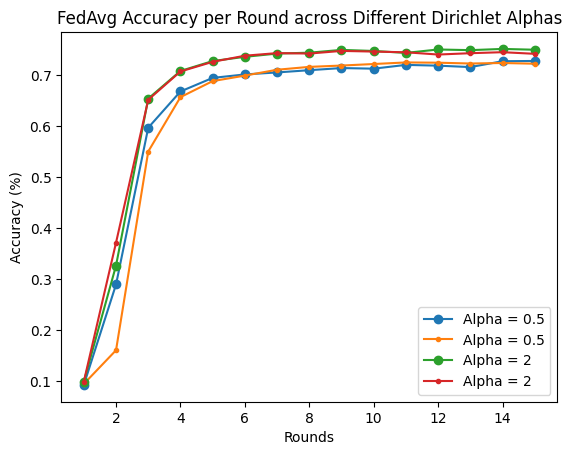

In [98]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')
    plt.plot(range(1, rounds + 1), accuracies_per_alpha_L2[idx], marker='.', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()

In [99]:
!pip install pot

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [101]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import ot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def compute_wasserstein_distance_pot(local_latents, global_latents):
    # # Convert to NumPy arrays for POT compatibility
    # local_latents_np = local_latents.cpu().numpy()
    # global_latents_np = global_latents.cpu().numpy()
    local_latents_np = local_latents.detach().cpu().numpy()
    global_latents_np = global_latents.detach().cpu().numpy()

    # Compute cost matrix (L2 distances)
    cost_matrix = ot.dist(local_latents_np, global_latents_np, metric='euclidean')

    # Uniform weights (assuming equal importance for each latent)
    num_local = local_latents.size(0)
    num_global = global_latents.size(0)
    local_weights = np.ones(num_local) / num_local
    global_weights = np.ones(num_global) / num_global

    # Solve optimal transport problem
    transport_plan = ot.emd(local_weights, global_weights, cost_matrix)

    # Compute Wasserstein distance
    wasserstein_distance = np.sum(transport_plan * cost_matrix)
    return torch.tensor(wasserstein_distance, device=local_latents.device)


def local_train_with_wasserstein_pot(model, train_loader, epochs, lr, lambda_reg):
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()
    model.eval()  # Ensure the global model is not updated

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_ce_loss = 0.0
        total_alignment_loss = 0.0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass on local model
            local_outputs = local_model(data)
            local_latents = local_model.get_latents(data)

            # Forward pass on global model
            with torch.no_grad():
                global_latents = model.get_latents(data)

            # Compute Cross-Entropy Loss (CE Loss)
            ce_loss = criterion(local_outputs, labels)

            # Compute Wasserstein Alignment Loss
            alignment_loss = compute_wasserstein_distance_pot(local_latents, global_latents)

            # Total loss
            loss = ce_loss + lambda_reg * alignment_loss
            loss.backward()
            optimizer.step()

            # Accumulate losses for logging
            total_ce_loss += ce_loss.item()
            total_alignment_loss += alignment_loss.item()

        # Print losses for this epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"  Cross-Entropy Loss: {total_ce_loss:.4f}")
        print(f"  Alignment Loss (Wasserstein): {total_alignment_loss:.4f}")

    # Compute updates (difference between global and local weights)
    overall_update = {
        name: param.data - model.state_dict()[name]
        for name, param in local_model.state_dict().items()
    }

    return overall_update


def fedavg_training_pot(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    """
    Federated Averaging with Wasserstein regularization using POT.

    Args:
        global_model: Global model shared by the server.
        train_loaders: List of DataLoaders for the clients' training datasets.
        num_clients: Number of clients.
        rounds: Number of communication rounds.
        epochs: Number of training epochs per client per round.
        lr: Learning rate for local training.
        test_loaders: List of DataLoaders for the clients' test datasets.

    Returns:
        round_avg_updates: List of averaged updates for each round.
        round_accuracies: List of global model accuracies for each round.
    """
    round_avg_updates = []
    round_accuracies = []
    global_model = global_model.to(device)

    for r in tqdm(range(rounds), desc="Communication Rounds", leave=True):
        client_updates = []

        # Distribute model and collect client updates
        for i in tqdm(range(num_clients), desc=f"Clients Training (Round {r+1})", leave=False):
            update = local_train_with_wasserstein_pot(global_model, train_loaders[i], epochs, lr, lambda_reg=0.3)
            client_updates.append(update)

        # Average updates
        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in global_model.state_dict().keys()}

        # Apply averaged updates to global model
        for name, param in global_model.state_dict().items():
            param.add_(avg_update[name])  # Update the global model in-place

        round_avg_updates.append(avg_update)

        # Evaluate the global model
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = global_model(data)
                    _, predicted = outputs.max(1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        accuracy = correct / total
        round_accuracies.append(accuracy)
        tqdm.write(f"Round {r+1} Accuracy: {accuracy:.4f}")

    return round_avg_updates, round_accuracies


In [102]:
# HyperParameters
num_clients = 5
batch_size = 128
rounds = 15
epochs = 5
lr = 0.001
dirichlet_alphas = [0.5, 2]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images, train_labels, test_images, test_labels, num_clients, alpha, batch_size)
    # print("============================== simple fedavg with l2 =======================================")
    # global_model_fedavg_L2 = SimpleCNN()
    # _, round_accuracies_L2 = fedavg_training_L2(global_model_fedavg_L2, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    # print("============================== simple fedavg=======================================")
    # global_model_fedavg = SimpleCNN()
    # _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    print("============================== simple fedavg with wassertein dist=======================================")
    global_model_fedavg_was = SimpleCNN()
    _, round_accuracies_was = fedavg_training_pot(global_model_fedavg_was, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies_was

# accuracies_per_alpha = []
# accuracies_per_alpha_L2 = []
accuracies_per_alpha_was = []
for alpha in dirichlet_alphas:
    round_accs_was = run_fedavg(alpha)
    # accuracies_per_alpha.append(round_accuracies)
    # accuracies_per_alpha_L2.append(round_accuracies_L2)
    accuracies_per_alpha_was.append(round_accs_was)


============================== simple fedavg with wassertein dist=======================================


Clients Training (Round 1):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 91.7154
  Alignment Loss (Wasserstein): 2432.3046
Epoch 2/5
  Cross-Entropy Loss: 60.0130
  Alignment Loss (Wasserstein): 2300.3169
Epoch 3/5
  Cross-Entropy Loss: 52.6070
  Alignment Loss (Wasserstein): 2311.6673
Epoch 4/5
  Cross-Entropy Loss: 49.7186
  Alignment Loss (Wasserstein): 2315.2947



Clients Training (Round 1):  20%|██        | 1/5 [00:10<00:42, 10.66s/it]

Epoch 5/5
  Cross-Entropy Loss: 44.6765
  Alignment Loss (Wasserstein): 2361.6395
Epoch 1/5
  Cross-Entropy Loss: 119.8982
  Alignment Loss (Wasserstein): 3552.2767
Epoch 2/5
  Cross-Entropy Loss: 86.0164
  Alignment Loss (Wasserstein): 3616.3646
Epoch 3/5
  Cross-Entropy Loss: 72.8020
  Alignment Loss (Wasserstein): 3744.8334
Epoch 4/5
  Cross-Entropy Loss: 65.0584
  Alignment Loss (Wasserstein): 3785.0000



Clients Training (Round 1):  40%|████      | 2/5 [00:27<00:42, 14.27s/it]

Epoch 5/5
  Cross-Entropy Loss: 55.9004
  Alignment Loss (Wasserstein): 3981.4901
Epoch 1/5
  Cross-Entropy Loss: 74.1374
  Alignment Loss (Wasserstein): 1887.6174
Epoch 2/5
  Cross-Entropy Loss: 60.8609
  Alignment Loss (Wasserstein): 1936.4217
Epoch 3/5
  Cross-Entropy Loss: 50.2273
  Alignment Loss (Wasserstein): 1996.0343
Epoch 4/5
  Cross-Entropy Loss: 44.0375
  Alignment Loss (Wasserstein): 2029.4725



Clients Training (Round 1):  60%|██████    | 3/5 [00:36<00:23, 11.99s/it]

Epoch 5/5
  Cross-Entropy Loss: 39.5810
  Alignment Loss (Wasserstein): 2062.1091
Epoch 1/5
  Cross-Entropy Loss: 109.3810
  Alignment Loss (Wasserstein): 4041.0647
Epoch 2/5
  Cross-Entropy Loss: 75.1730
  Alignment Loss (Wasserstein): 4148.0782
Epoch 3/5
  Cross-Entropy Loss: 66.7177
  Alignment Loss (Wasserstein): 4196.7221
Epoch 4/5
  Cross-Entropy Loss: 55.4757
  Alignment Loss (Wasserstein): 4232.9198



Clients Training (Round 1):  80%|████████  | 4/5 [00:55<00:14, 14.67s/it]

Epoch 5/5
  Cross-Entropy Loss: 44.5324
  Alignment Loss (Wasserstein): 4385.2636
Epoch 1/5
  Cross-Entropy Loss: 170.6100
  Alignment Loss (Wasserstein): 5173.7262
Epoch 2/5
  Cross-Entropy Loss: 134.9597
  Alignment Loss (Wasserstein): 5293.7052
Epoch 3/5
  Cross-Entropy Loss: 118.8313
  Alignment Loss (Wasserstein): 5393.7632
Epoch 4/5
  Cross-Entropy Loss: 106.5748
  Alignment Loss (Wasserstein): 5546.9373



Clients Training (Round 1): 100%|██████████| 5/5 [01:19<00:00, 18.06s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 93.5578
  Alignment Loss (Wasserstein): 5728.0188


Communication Rounds:   7%|▋         | 1/15 [01:20<18:44, 80.34s/it]

Round 1 Accuracy: 0.0982



Clients Training (Round 2):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 65.3634
  Alignment Loss (Wasserstein): 447.0557
Epoch 2/5
  Cross-Entropy Loss: 49.8032
  Alignment Loss (Wasserstein): 675.4995
Epoch 3/5
  Cross-Entropy Loss: 42.1520
  Alignment Loss (Wasserstein): 803.6076
Epoch 4/5
  Cross-Entropy Loss: 35.1919
  Alignment Loss (Wasserstein): 951.1663



Clients Training (Round 2):  20%|██        | 1/5 [00:11<00:44, 11.04s/it]

Epoch 5/5
  Cross-Entropy Loss: 31.0136
  Alignment Loss (Wasserstein): 1125.1036
Epoch 1/5
  Cross-Entropy Loss: 97.5556
  Alignment Loss (Wasserstein): 679.3203
Epoch 2/5
  Cross-Entropy Loss: 73.0392
  Alignment Loss (Wasserstein): 1032.8269
Epoch 3/5
  Cross-Entropy Loss: 62.0414
  Alignment Loss (Wasserstein): 1275.9409
Epoch 4/5
  Cross-Entropy Loss: 53.4490
  Alignment Loss (Wasserstein): 1431.2215



Clients Training (Round 2):  40%|████      | 2/5 [00:27<00:42, 14.16s/it]

Epoch 5/5
  Cross-Entropy Loss: 42.1546
  Alignment Loss (Wasserstein): 1806.8446
Epoch 1/5
  Cross-Entropy Loss: 59.6288
  Alignment Loss (Wasserstein): 386.8228
Epoch 2/5
  Cross-Entropy Loss: 44.2988
  Alignment Loss (Wasserstein): 583.4979
Epoch 3/5
  Cross-Entropy Loss: 35.3247
  Alignment Loss (Wasserstein): 741.5733
Epoch 4/5
  Cross-Entropy Loss: 29.5533
  Alignment Loss (Wasserstein): 886.3633



Clients Training (Round 2):  60%|██████    | 3/5 [00:36<00:24, 12.01s/it]

Epoch 5/5
  Cross-Entropy Loss: 24.1052
  Alignment Loss (Wasserstein): 1061.8281
Epoch 1/5
  Cross-Entropy Loss: 90.9354
  Alignment Loss (Wasserstein): 1289.4315
Epoch 2/5
  Cross-Entropy Loss: 60.8901
  Alignment Loss (Wasserstein): 1776.8574
Epoch 3/5
  Cross-Entropy Loss: 45.9875
  Alignment Loss (Wasserstein): 2168.8908
Epoch 4/5
  Cross-Entropy Loss: 35.2023
  Alignment Loss (Wasserstein): 2552.8035



Clients Training (Round 2):  80%|████████  | 4/5 [00:55<00:14, 14.73s/it]

Epoch 5/5
  Cross-Entropy Loss: 29.3288
  Alignment Loss (Wasserstein): 2829.6842
Epoch 1/5
  Cross-Entropy Loss: 140.8698
  Alignment Loss (Wasserstein): 1120.5556
Epoch 2/5
  Cross-Entropy Loss: 113.2893
  Alignment Loss (Wasserstein): 1509.7622
Epoch 3/5
  Cross-Entropy Loss: 96.4862
  Alignment Loss (Wasserstein): 1760.1853
Epoch 4/5
  Cross-Entropy Loss: 79.0018
  Alignment Loss (Wasserstein): 2119.1557



Clients Training (Round 2): 100%|██████████| 5/5 [01:20<00:00, 18.30s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 63.9143
  Alignment Loss (Wasserstein): 2665.5637


Communication Rounds:  13%|█▎        | 2/15 [02:41<17:30, 80.80s/it]

Round 2 Accuracy: 0.3073



Clients Training (Round 3):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 46.8270
  Alignment Loss (Wasserstein): 547.0371
Epoch 2/5
  Cross-Entropy Loss: 34.6398
  Alignment Loss (Wasserstein): 795.3976
Epoch 3/5
  Cross-Entropy Loss: 25.4257
  Alignment Loss (Wasserstein): 1081.3757
Epoch 4/5
  Cross-Entropy Loss: 18.9733
  Alignment Loss (Wasserstein): 1425.4100



Clients Training (Round 3):  20%|██        | 1/5 [00:10<00:43, 10.92s/it]

Epoch 5/5
  Cross-Entropy Loss: 13.3263
  Alignment Loss (Wasserstein): 1832.3031
Epoch 1/5
  Cross-Entropy Loss: 72.6529
  Alignment Loss (Wasserstein): 869.1151
Epoch 2/5
  Cross-Entropy Loss: 53.7920
  Alignment Loss (Wasserstein): 1332.4149
Epoch 3/5
  Cross-Entropy Loss: 40.6617
  Alignment Loss (Wasserstein): 1775.9401
Epoch 4/5
  Cross-Entropy Loss: 29.1527
  Alignment Loss (Wasserstein): 2441.2250



Clients Training (Round 3):  40%|████      | 2/5 [00:27<00:43, 14.42s/it]

Epoch 5/5
  Cross-Entropy Loss: 20.1948
  Alignment Loss (Wasserstein): 3131.3646
Epoch 1/5
  Cross-Entropy Loss: 39.7402
  Alignment Loss (Wasserstein): 527.7743
Epoch 2/5
  Cross-Entropy Loss: 28.1772
  Alignment Loss (Wasserstein): 743.2357
Epoch 3/5
  Cross-Entropy Loss: 21.6823
  Alignment Loss (Wasserstein): 947.0571
Epoch 4/5
  Cross-Entropy Loss: 15.0772
  Alignment Loss (Wasserstein): 1268.2729



Clients Training (Round 3):  60%|██████    | 3/5 [00:37<00:24, 12.13s/it]

Epoch 5/5
  Cross-Entropy Loss: 9.4584
  Alignment Loss (Wasserstein): 1687.5284
Epoch 1/5
  Cross-Entropy Loss: 61.1477
  Alignment Loss (Wasserstein): 1302.8788
Epoch 2/5
  Cross-Entropy Loss: 38.2080
  Alignment Loss (Wasserstein): 1724.2131
Epoch 3/5
  Cross-Entropy Loss: 27.2739
  Alignment Loss (Wasserstein): 2163.2092
Epoch 4/5
  Cross-Entropy Loss: 21.6594
  Alignment Loss (Wasserstein): 2563.2713



Clients Training (Round 3):  80%|████████  | 4/5 [00:56<00:14, 14.89s/it]

Epoch 5/5
  Cross-Entropy Loss: 12.2315
  Alignment Loss (Wasserstein): 3485.5899
Epoch 1/5
  Cross-Entropy Loss: 112.0721
  Alignment Loss (Wasserstein): 1347.2754
Epoch 2/5
  Cross-Entropy Loss: 83.3823
  Alignment Loss (Wasserstein): 2011.4055
Epoch 3/5
  Cross-Entropy Loss: 63.8896
  Alignment Loss (Wasserstein): 2600.7352
Epoch 4/5
  Cross-Entropy Loss: 46.5200
  Alignment Loss (Wasserstein): 3512.3966



Clients Training (Round 3): 100%|██████████| 5/5 [01:20<00:00, 18.39s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 30.3265
  Alignment Loss (Wasserstein): 4641.6227


Communication Rounds:  20%|██        | 3/15 [04:03<16:14, 81.19s/it]

Round 3 Accuracy: 0.5888



Clients Training (Round 4):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 32.7260
  Alignment Loss (Wasserstein): 736.5775
Epoch 2/5
  Cross-Entropy Loss: 19.9273
  Alignment Loss (Wasserstein): 1030.5409
Epoch 3/5
  Cross-Entropy Loss: 11.5070
  Alignment Loss (Wasserstein): 1514.0600
Epoch 4/5
  Cross-Entropy Loss: 6.2016
  Alignment Loss (Wasserstein): 2136.3101



Clients Training (Round 4):  20%|██        | 1/5 [00:11<00:44, 11.15s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.4818
  Alignment Loss (Wasserstein): 2778.0375
Epoch 1/5
  Cross-Entropy Loss: 51.8832
  Alignment Loss (Wasserstein): 1133.0229
Epoch 2/5
  Cross-Entropy Loss: 33.9904
  Alignment Loss (Wasserstein): 1623.0887
Epoch 3/5
  Cross-Entropy Loss: 18.6253
  Alignment Loss (Wasserstein): 2521.5487
Epoch 4/5
  Cross-Entropy Loss: 12.0640
  Alignment Loss (Wasserstein): 3386.6624



Clients Training (Round 4):  40%|████      | 2/5 [00:28<00:43, 14.63s/it]

Epoch 5/5
  Cross-Entropy Loss: 8.4943
  Alignment Loss (Wasserstein): 4023.6965
Epoch 1/5
  Cross-Entropy Loss: 30.5865
  Alignment Loss (Wasserstein): 577.6196
Epoch 2/5
  Cross-Entropy Loss: 16.4314
  Alignment Loss (Wasserstein): 822.1997
Epoch 3/5
  Cross-Entropy Loss: 8.8230
  Alignment Loss (Wasserstein): 1240.2820
Epoch 4/5
  Cross-Entropy Loss: 4.1106
  Alignment Loss (Wasserstein): 1783.9119



Clients Training (Round 4):  60%|██████    | 3/5 [00:37<00:24, 12.35s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.2227
  Alignment Loss (Wasserstein): 2263.1140
Epoch 1/5
  Cross-Entropy Loss: 37.4944
  Alignment Loss (Wasserstein): 1422.7206
Epoch 2/5
  Cross-Entropy Loss: 22.2619
  Alignment Loss (Wasserstein): 1954.7841
Epoch 3/5
  Cross-Entropy Loss: 12.6498
  Alignment Loss (Wasserstein): 2801.6882
Epoch 4/5
  Cross-Entropy Loss: 9.2277
  Alignment Loss (Wasserstein): 3274.8019



Clients Training (Round 4):  80%|████████  | 4/5 [00:57<00:15, 15.12s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.9055
  Alignment Loss (Wasserstein): 4157.6076
Epoch 1/5
  Cross-Entropy Loss: 81.2195
  Alignment Loss (Wasserstein): 1768.1105
Epoch 2/5
  Cross-Entropy Loss: 56.1903
  Alignment Loss (Wasserstein): 2580.0004
Epoch 3/5
  Cross-Entropy Loss: 34.2170
  Alignment Loss (Wasserstein): 3822.3983
Epoch 4/5
  Cross-Entropy Loss: 22.3374
  Alignment Loss (Wasserstein): 4994.8982



Clients Training (Round 4): 100%|██████████| 5/5 [01:23<00:00, 18.99s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 14.7708
  Alignment Loss (Wasserstein): 6018.9329


Communication Rounds:  27%|██▋       | 4/15 [05:26<15:04, 82.23s/it]

Round 4 Accuracy: 0.6435



Clients Training (Round 5):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 24.6211
  Alignment Loss (Wasserstein): 1061.4892
Epoch 2/5
  Cross-Entropy Loss: 9.3789
  Alignment Loss (Wasserstein): 1479.8120
Epoch 3/5
  Cross-Entropy Loss: 4.6255
  Alignment Loss (Wasserstein): 2081.6561
Epoch 4/5
  Cross-Entropy Loss: 3.7186
  Alignment Loss (Wasserstein): 2368.5569



Clients Training (Round 5):  20%|██        | 1/5 [00:11<00:44, 11.09s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.1906
  Alignment Loss (Wasserstein): 2641.4217
Epoch 1/5
  Cross-Entropy Loss: 38.7203
  Alignment Loss (Wasserstein): 1733.1518
Epoch 2/5
  Cross-Entropy Loss: 17.6221
  Alignment Loss (Wasserstein): 2423.0345
Epoch 3/5
  Cross-Entropy Loss: 9.2264
  Alignment Loss (Wasserstein): 3337.7976
Epoch 4/5
  Cross-Entropy Loss: 7.7275
  Alignment Loss (Wasserstein): 3900.9915



Clients Training (Round 5):  40%|████      | 2/5 [00:27<00:43, 14.51s/it]

Epoch 5/5
  Cross-Entropy Loss: 6.7084
  Alignment Loss (Wasserstein): 4096.8446
Epoch 1/5
  Cross-Entropy Loss: 21.0718
  Alignment Loss (Wasserstein): 869.9577
Epoch 2/5
  Cross-Entropy Loss: 7.2637
  Alignment Loss (Wasserstein): 1127.6439
Epoch 3/5
  Cross-Entropy Loss: 2.6559
  Alignment Loss (Wasserstein): 1671.3150
Epoch 4/5
  Cross-Entropy Loss: 1.3585
  Alignment Loss (Wasserstein): 2024.3408



Clients Training (Round 5):  60%|██████    | 3/5 [00:37<00:24, 12.13s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.7932
  Alignment Loss (Wasserstein): 2282.4473
Epoch 1/5
  Cross-Entropy Loss: 28.1718
  Alignment Loss (Wasserstein): 2080.2090
Epoch 2/5
  Cross-Entropy Loss: 11.8229
  Alignment Loss (Wasserstein): 2717.0108
Epoch 3/5
  Cross-Entropy Loss: 6.7403
  Alignment Loss (Wasserstein): 3363.2908
Epoch 4/5
  Cross-Entropy Loss: 5.8438
  Alignment Loss (Wasserstein): 3871.8290



Clients Training (Round 5):  80%|████████  | 4/5 [00:56<00:14, 14.96s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.5197
  Alignment Loss (Wasserstein): 4145.7847
Epoch 1/5
  Cross-Entropy Loss: 63.4247
  Alignment Loss (Wasserstein): 2537.1260
Epoch 2/5
  Cross-Entropy Loss: 32.2163
  Alignment Loss (Wasserstein): 3619.3005
Epoch 3/5
  Cross-Entropy Loss: 18.2905
  Alignment Loss (Wasserstein): 4887.2459
Epoch 4/5
  Cross-Entropy Loss: 13.9168
  Alignment Loss (Wasserstein): 5620.7252



Clients Training (Round 5): 100%|██████████| 5/5 [01:21<00:00, 18.47s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 12.6474
  Alignment Loss (Wasserstein): 6176.3875


Communication Rounds:  33%|███▎      | 5/15 [06:48<13:41, 82.16s/it]

Round 5 Accuracy: 0.6816



Clients Training (Round 6):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 18.8448
  Alignment Loss (Wasserstein): 1293.1268
Epoch 2/5
  Cross-Entropy Loss: 5.0540
  Alignment Loss (Wasserstein): 1786.1810
Epoch 3/5
  Cross-Entropy Loss: 2.5293
  Alignment Loss (Wasserstein): 2358.3695
Epoch 4/5
  Cross-Entropy Loss: 3.4269
  Alignment Loss (Wasserstein): 2660.5890



Clients Training (Round 6):  20%|██        | 1/5 [00:11<00:44, 11.08s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.8578
  Alignment Loss (Wasserstein): 2412.2901
Epoch 1/5
  Cross-Entropy Loss: 29.1822
  Alignment Loss (Wasserstein): 2081.8283
Epoch 2/5
  Cross-Entropy Loss: 8.6998
  Alignment Loss (Wasserstein): 3060.7587
Epoch 3/5
  Cross-Entropy Loss: 4.6465
  Alignment Loss (Wasserstein): 3962.2473
Epoch 4/5
  Cross-Entropy Loss: 6.6515
  Alignment Loss (Wasserstein): 4240.4281



Clients Training (Round 6):  40%|████      | 2/5 [00:27<00:42, 14.33s/it]

Epoch 5/5
  Cross-Entropy Loss: 7.8420
  Alignment Loss (Wasserstein): 4093.3780
Epoch 1/5
  Cross-Entropy Loss: 15.0234
  Alignment Loss (Wasserstein): 1062.5589
Epoch 2/5
  Cross-Entropy Loss: 3.4426
  Alignment Loss (Wasserstein): 1506.4279
Epoch 3/5
  Cross-Entropy Loss: 1.7309
  Alignment Loss (Wasserstein): 1819.2354
Epoch 4/5
  Cross-Entropy Loss: 1.0489
  Alignment Loss (Wasserstein): 2156.0036



Clients Training (Round 6):  60%|██████    | 3/5 [00:37<00:24, 12.15s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.1563
  Alignment Loss (Wasserstein): 2449.4492
Epoch 1/5
  Cross-Entropy Loss: 21.2563
  Alignment Loss (Wasserstein): 2513.6750
Epoch 2/5
  Cross-Entropy Loss: 6.2775
  Alignment Loss (Wasserstein): 3320.9002
Epoch 3/5
  Cross-Entropy Loss: 5.2665
  Alignment Loss (Wasserstein): 3888.1637
Epoch 4/5
  Cross-Entropy Loss: 6.0773
  Alignment Loss (Wasserstein): 4056.8253



Clients Training (Round 6):  80%|████████  | 4/5 [00:55<00:14, 14.74s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.1063
  Alignment Loss (Wasserstein): 4459.5033
Epoch 1/5
  Cross-Entropy Loss: 47.5899
  Alignment Loss (Wasserstein): 3119.6050
Epoch 2/5
  Cross-Entropy Loss: 20.8479
  Alignment Loss (Wasserstein): 4458.8085
Epoch 3/5
  Cross-Entropy Loss: 13.8647
  Alignment Loss (Wasserstein): 5290.7864
Epoch 4/5
  Cross-Entropy Loss: 11.5113
  Alignment Loss (Wasserstein): 5949.6203



Clients Training (Round 6): 100%|██████████| 5/5 [01:20<00:00, 18.44s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 10.1243
  Alignment Loss (Wasserstein): 6018.4747


Communication Rounds:  40%|████      | 6/15 [08:10<12:18, 82.00s/it]

Round 6 Accuracy: 0.6948



Clients Training (Round 7):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 14.7318
  Alignment Loss (Wasserstein): 1453.5877
Epoch 2/5
  Cross-Entropy Loss: 4.9689
  Alignment Loss (Wasserstein): 1972.8764
Epoch 3/5
  Cross-Entropy Loss: 2.4040
  Alignment Loss (Wasserstein): 2310.2118
Epoch 4/5
  Cross-Entropy Loss: 2.4042
  Alignment Loss (Wasserstein): 2808.6054



Clients Training (Round 7):  20%|██        | 1/5 [00:10<00:43, 10.89s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.1955
  Alignment Loss (Wasserstein): 2749.0808
Epoch 1/5
  Cross-Entropy Loss: 22.1748
  Alignment Loss (Wasserstein): 2333.8537
Epoch 2/5
  Cross-Entropy Loss: 6.8663
  Alignment Loss (Wasserstein): 3308.9363
Epoch 3/5
  Cross-Entropy Loss: 5.5287
  Alignment Loss (Wasserstein): 3820.8773
Epoch 4/5
  Cross-Entropy Loss: 5.0377
  Alignment Loss (Wasserstein): 4403.2032



Clients Training (Round 7):  40%|████      | 2/5 [00:27<00:43, 14.43s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.5420
  Alignment Loss (Wasserstein): 4458.1935
Epoch 1/5
  Cross-Entropy Loss: 11.9787
  Alignment Loss (Wasserstein): 1147.6311
Epoch 2/5
  Cross-Entropy Loss: 2.2588
  Alignment Loss (Wasserstein): 1551.7929
Epoch 3/5
  Cross-Entropy Loss: 2.1114
  Alignment Loss (Wasserstein): 1947.3479
Epoch 4/5
  Cross-Entropy Loss: 1.7144
  Alignment Loss (Wasserstein): 2108.5519



Clients Training (Round 7):  60%|██████    | 3/5 [00:37<00:24, 12.07s/it]

Epoch 5/5
  Cross-Entropy Loss: 0.9675
  Alignment Loss (Wasserstein): 2471.8054
Epoch 1/5
  Cross-Entropy Loss: 16.2764
  Alignment Loss (Wasserstein): 2823.3354
Epoch 2/5
  Cross-Entropy Loss: 4.2054
  Alignment Loss (Wasserstein): 3593.2610
Epoch 3/5
  Cross-Entropy Loss: 3.9297
  Alignment Loss (Wasserstein): 4213.1045
Epoch 4/5
  Cross-Entropy Loss: 6.4435
  Alignment Loss (Wasserstein): 4123.9988



Clients Training (Round 7):  80%|████████  | 4/5 [00:55<00:14, 14.75s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.8048
  Alignment Loss (Wasserstein): 4282.5189
Epoch 1/5
  Cross-Entropy Loss: 36.9791
  Alignment Loss (Wasserstein): 3468.0424
Epoch 2/5
  Cross-Entropy Loss: 13.6596
  Alignment Loss (Wasserstein): 5225.6913
Epoch 3/5
  Cross-Entropy Loss: 13.5813
  Alignment Loss (Wasserstein): 5501.5960
Epoch 4/5
  Cross-Entropy Loss: 12.6064
  Alignment Loss (Wasserstein): 5859.0514



Clients Training (Round 7): 100%|██████████| 5/5 [01:20<00:00, 18.38s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 9.5861
  Alignment Loss (Wasserstein): 5986.5122


Communication Rounds:  47%|████▋     | 7/15 [09:32<10:54, 81.83s/it]

Round 7 Accuracy: 0.7043



Clients Training (Round 8):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 10.4596
  Alignment Loss (Wasserstein): 1512.6585
Epoch 2/5
  Cross-Entropy Loss: 2.6327
  Alignment Loss (Wasserstein): 2086.8482
Epoch 3/5
  Cross-Entropy Loss: 1.6097
  Alignment Loss (Wasserstein): 2667.0379
Epoch 4/5
  Cross-Entropy Loss: 3.0507
  Alignment Loss (Wasserstein): 2788.1593



Clients Training (Round 8):  20%|██        | 1/5 [00:11<00:44, 11.21s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.4009
  Alignment Loss (Wasserstein): 2771.8944
Epoch 1/5
  Cross-Entropy Loss: 15.9792
  Alignment Loss (Wasserstein): 2563.4340
Epoch 2/5
  Cross-Entropy Loss: 5.1104
  Alignment Loss (Wasserstein): 3464.5287
Epoch 3/5
  Cross-Entropy Loss: 5.2547
  Alignment Loss (Wasserstein): 4341.0695
Epoch 4/5
  Cross-Entropy Loss: 6.7613
  Alignment Loss (Wasserstein): 4117.4878



Clients Training (Round 8):  40%|████      | 2/5 [00:27<00:42, 14.32s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.6424
  Alignment Loss (Wasserstein): 4377.6631
Epoch 1/5
  Cross-Entropy Loss: 8.6225
  Alignment Loss (Wasserstein): 1232.7348
Epoch 2/5
  Cross-Entropy Loss: 1.9989
  Alignment Loss (Wasserstein): 1679.1465
Epoch 3/5
  Cross-Entropy Loss: 2.3052
  Alignment Loss (Wasserstein): 1902.3991
Epoch 4/5
  Cross-Entropy Loss: 1.7256
  Alignment Loss (Wasserstein): 2078.2719



Clients Training (Round 8):  60%|██████    | 3/5 [00:36<00:23, 11.98s/it]

Epoch 5/5
  Cross-Entropy Loss: 1.3529
  Alignment Loss (Wasserstein): 2269.9677
Epoch 1/5
  Cross-Entropy Loss: 12.5255
  Alignment Loss (Wasserstein): 3046.7406
Epoch 2/5
  Cross-Entropy Loss: 5.1357
  Alignment Loss (Wasserstein): 3919.9226
Epoch 3/5
  Cross-Entropy Loss: 6.1112
  Alignment Loss (Wasserstein): 4235.9658
Epoch 4/5
  Cross-Entropy Loss: 3.9771
  Alignment Loss (Wasserstein): 4402.1939



Clients Training (Round 8):  80%|████████  | 4/5 [00:55<00:14, 14.55s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.6614
  Alignment Loss (Wasserstein): 4450.5445
Epoch 1/5
  Cross-Entropy Loss: 28.0505
  Alignment Loss (Wasserstein): 3765.3213
Epoch 2/5
  Cross-Entropy Loss: 10.4184
  Alignment Loss (Wasserstein): 5105.1621
Epoch 3/5
  Cross-Entropy Loss: 10.6110
  Alignment Loss (Wasserstein): 5778.7606
Epoch 4/5
  Cross-Entropy Loss: 13.0094
  Alignment Loss (Wasserstein): 5796.2636



Clients Training (Round 8): 100%|██████████| 5/5 [01:20<00:00, 18.30s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 9.7146
  Alignment Loss (Wasserstein): 6020.0185


Communication Rounds:  53%|█████▎    | 8/15 [10:53<09:31, 81.59s/it]

Round 8 Accuracy: 0.7014



Clients Training (Round 9):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 8.2577
  Alignment Loss (Wasserstein): 1470.7560
Epoch 2/5
  Cross-Entropy Loss: 2.0548
  Alignment Loss (Wasserstein): 2244.0396
Epoch 3/5
  Cross-Entropy Loss: 2.8807
  Alignment Loss (Wasserstein): 2551.2951
Epoch 4/5
  Cross-Entropy Loss: 2.7182
  Alignment Loss (Wasserstein): 2491.4427



Clients Training (Round 9):  20%|██        | 1/5 [00:10<00:43, 10.85s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.5739
  Alignment Loss (Wasserstein): 2607.8101
Epoch 1/5
  Cross-Entropy Loss: 12.8799
  Alignment Loss (Wasserstein): 2702.7628
Epoch 2/5
  Cross-Entropy Loss: 4.9174
  Alignment Loss (Wasserstein): 3779.5097
Epoch 3/5
  Cross-Entropy Loss: 5.3825
  Alignment Loss (Wasserstein): 4185.5063
Epoch 4/5
  Cross-Entropy Loss: 5.6323
  Alignment Loss (Wasserstein): 4219.7100



Clients Training (Round 9):  40%|████      | 2/5 [00:27<00:43, 14.40s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.6661
  Alignment Loss (Wasserstein): 4474.0971
Epoch 1/5
  Cross-Entropy Loss: 7.1030
  Alignment Loss (Wasserstein): 1243.6049
Epoch 2/5
  Cross-Entropy Loss: 1.3718
  Alignment Loss (Wasserstein): 1726.8281
Epoch 3/5
  Cross-Entropy Loss: 0.6262
  Alignment Loss (Wasserstein): 2311.2076
Epoch 4/5
  Cross-Entropy Loss: 2.8725
  Alignment Loss (Wasserstein): 2229.0924



Clients Training (Round 9):  60%|██████    | 3/5 [00:36<00:24, 12.01s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.7843
  Alignment Loss (Wasserstein): 2226.7018
Epoch 1/5
  Cross-Entropy Loss: 9.5985
  Alignment Loss (Wasserstein): 3149.9368
Epoch 2/5
  Cross-Entropy Loss: 3.9826
  Alignment Loss (Wasserstein): 4131.7336
Epoch 3/5
  Cross-Entropy Loss: 5.8511
  Alignment Loss (Wasserstein): 4305.1241
Epoch 4/5
  Cross-Entropy Loss: 4.6062
  Alignment Loss (Wasserstein): 4579.7002



Clients Training (Round 9):  80%|████████  | 4/5 [00:55<00:14, 14.73s/it]

Epoch 5/5
  Cross-Entropy Loss: 6.0392
  Alignment Loss (Wasserstein): 4801.1065
Epoch 1/5
  Cross-Entropy Loss: 22.5805
  Alignment Loss (Wasserstein): 3967.8223
Epoch 2/5
  Cross-Entropy Loss: 11.1521
  Alignment Loss (Wasserstein): 5439.6758
Epoch 3/5
  Cross-Entropy Loss: 11.7674
  Alignment Loss (Wasserstein): 5810.5238
Epoch 4/5
  Cross-Entropy Loss: 11.0133
  Alignment Loss (Wasserstein): 5944.3058



Clients Training (Round 9): 100%|██████████| 5/5 [01:20<00:00, 18.35s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 7.9770
  Alignment Loss (Wasserstein): 5981.0616


Communication Rounds:  60%|██████    | 9/15 [12:14<08:09, 81.51s/it]

Round 9 Accuracy: 0.7115



Clients Training (Round 10):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 6.4472
  Alignment Loss (Wasserstein): 1628.0037
Epoch 2/5
  Cross-Entropy Loss: 3.1139
  Alignment Loss (Wasserstein): 2303.9029
Epoch 3/5
  Cross-Entropy Loss: 2.1427
  Alignment Loss (Wasserstein): 2567.8980
Epoch 4/5
  Cross-Entropy Loss: 2.7698
  Alignment Loss (Wasserstein): 2678.8912



Clients Training (Round 10):  20%|██        | 1/5 [00:11<00:45, 11.38s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.2734
  Alignment Loss (Wasserstein): 2892.7445
Epoch 1/5
  Cross-Entropy Loss: 9.8435
  Alignment Loss (Wasserstein): 2848.0887
Epoch 2/5
  Cross-Entropy Loss: 4.9035
  Alignment Loss (Wasserstein): 3757.1299
Epoch 3/5
  Cross-Entropy Loss: 4.6747
  Alignment Loss (Wasserstein): 4003.8266
Epoch 4/5
  Cross-Entropy Loss: 6.2079
  Alignment Loss (Wasserstein): 4310.6775



Clients Training (Round 10):  40%|████      | 2/5 [00:28<00:43, 14.51s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.2790
  Alignment Loss (Wasserstein): 4328.9678
Epoch 1/5
  Cross-Entropy Loss: 6.4525
  Alignment Loss (Wasserstein): 1244.5107
Epoch 2/5
  Cross-Entropy Loss: 1.2337
  Alignment Loss (Wasserstein): 1808.8000
Epoch 3/5
  Cross-Entropy Loss: 0.7281
  Alignment Loss (Wasserstein): 2207.1198
Epoch 4/5
  Cross-Entropy Loss: 0.8766
  Alignment Loss (Wasserstein): 2303.0897



Clients Training (Round 10):  60%|██████    | 3/5 [00:37<00:24, 12.17s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.8375
  Alignment Loss (Wasserstein): 2531.2750
Epoch 1/5
  Cross-Entropy Loss: 7.9436
  Alignment Loss (Wasserstein): 3077.6495
Epoch 2/5
  Cross-Entropy Loss: 4.2824
  Alignment Loss (Wasserstein): 4169.8880
Epoch 3/5
  Cross-Entropy Loss: 6.8054
  Alignment Loss (Wasserstein): 4520.1737
Epoch 4/5
  Cross-Entropy Loss: 5.7778
  Alignment Loss (Wasserstein): 4159.0848



Clients Training (Round 10):  80%|████████  | 4/5 [00:56<00:14, 14.78s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.4229
  Alignment Loss (Wasserstein): 4504.5841
Epoch 1/5
  Cross-Entropy Loss: 17.8304
  Alignment Loss (Wasserstein): 4141.2746
Epoch 2/5
  Cross-Entropy Loss: 10.6043
  Alignment Loss (Wasserstein): 5550.5232
Epoch 3/5
  Cross-Entropy Loss: 11.5154
  Alignment Loss (Wasserstein): 5688.8932
Epoch 4/5
  Cross-Entropy Loss: 9.2271
  Alignment Loss (Wasserstein): 5926.8722



Clients Training (Round 10): 100%|██████████| 5/5 [01:21<00:00, 18.59s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 10.3561
  Alignment Loss (Wasserstein): 6056.2663


Communication Rounds:  67%|██████▋   | 10/15 [13:36<06:48, 81.76s/it]

Round 10 Accuracy: 0.7126



Clients Training (Round 11):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 5.3289
  Alignment Loss (Wasserstein): 1612.2635
Epoch 2/5
  Cross-Entropy Loss: 2.1181
  Alignment Loss (Wasserstein): 2376.5752
Epoch 3/5
  Cross-Entropy Loss: 2.1250
  Alignment Loss (Wasserstein): 2718.9061
Epoch 4/5
  Cross-Entropy Loss: 4.1950
  Alignment Loss (Wasserstein): 2635.3988



Clients Training (Round 11):  20%|██        | 1/5 [00:10<00:43, 10.90s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.7661
  Alignment Loss (Wasserstein): 2557.0595
Epoch 1/5
  Cross-Entropy Loss: 7.5193
  Alignment Loss (Wasserstein): 2937.1858
Epoch 2/5
  Cross-Entropy Loss: 6.1529
  Alignment Loss (Wasserstein): 3908.2071
Epoch 3/5
  Cross-Entropy Loss: 5.9971
  Alignment Loss (Wasserstein): 3962.0254
Epoch 4/5
  Cross-Entropy Loss: 4.7042
  Alignment Loss (Wasserstein): 4304.4727



Clients Training (Round 11):  40%|████      | 2/5 [00:27<00:43, 14.43s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.2892
  Alignment Loss (Wasserstein): 4266.4034
Epoch 1/5
  Cross-Entropy Loss: 4.6321
  Alignment Loss (Wasserstein): 1329.2794
Epoch 2/5
  Cross-Entropy Loss: 1.4441
  Alignment Loss (Wasserstein): 1882.2910
Epoch 3/5
  Cross-Entropy Loss: 1.6284
  Alignment Loss (Wasserstein): 2385.0336
Epoch 4/5
  Cross-Entropy Loss: 4.0033
  Alignment Loss (Wasserstein): 2366.5902



Clients Training (Round 11):  60%|██████    | 3/5 [00:37<00:24, 12.08s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.4376
  Alignment Loss (Wasserstein): 2255.6578
Epoch 1/5
  Cross-Entropy Loss: 7.5214
  Alignment Loss (Wasserstein): 3335.7154
Epoch 2/5
  Cross-Entropy Loss: 3.9757
  Alignment Loss (Wasserstein): 4157.6237
Epoch 3/5
  Cross-Entropy Loss: 5.3465
  Alignment Loss (Wasserstein): 4444.8680
Epoch 4/5
  Cross-Entropy Loss: 4.1922
  Alignment Loss (Wasserstein): 4611.7208



Clients Training (Round 11):  80%|████████  | 4/5 [00:56<00:14, 14.79s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.7177
  Alignment Loss (Wasserstein): 4688.8078
Epoch 1/5
  Cross-Entropy Loss: 14.7272
  Alignment Loss (Wasserstein): 4370.7730
Epoch 2/5
  Cross-Entropy Loss: 8.7793
  Alignment Loss (Wasserstein): 5549.3743
Epoch 3/5
  Cross-Entropy Loss: 8.9145
  Alignment Loss (Wasserstein): 6156.0885
Epoch 4/5
  Cross-Entropy Loss: 11.8314
  Alignment Loss (Wasserstein): 6021.3177



Clients Training (Round 11): 100%|██████████| 5/5 [01:20<00:00, 18.40s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 10.4935
  Alignment Loss (Wasserstein): 6143.2292


Communication Rounds:  73%|███████▎  | 11/15 [14:58<05:26, 81.70s/it]

Round 11 Accuracy: 0.7141



Clients Training (Round 12):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 4.5312
  Alignment Loss (Wasserstein): 1659.1904
Epoch 2/5
  Cross-Entropy Loss: 1.8576
  Alignment Loss (Wasserstein): 2418.0721
Epoch 3/5
  Cross-Entropy Loss: 2.2798
  Alignment Loss (Wasserstein): 2790.2618
Epoch 4/5
  Cross-Entropy Loss: 3.7026
  Alignment Loss (Wasserstein): 2694.7105



Clients Training (Round 12):  20%|██        | 1/5 [00:11<00:45, 11.32s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.4727
  Alignment Loss (Wasserstein): 2439.1982
Epoch 1/5
  Cross-Entropy Loss: 6.6419
  Alignment Loss (Wasserstein): 2930.6545
Epoch 2/5
  Cross-Entropy Loss: 5.4800
  Alignment Loss (Wasserstein): 4177.3987
Epoch 3/5
  Cross-Entropy Loss: 6.3183
  Alignment Loss (Wasserstein): 4151.3141
Epoch 4/5
  Cross-Entropy Loss: 5.1443
  Alignment Loss (Wasserstein): 4226.6005



Clients Training (Round 12):  40%|████      | 2/5 [00:28<00:43, 14.53s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.6526
  Alignment Loss (Wasserstein): 4395.4459
Epoch 1/5
  Cross-Entropy Loss: 3.4858
  Alignment Loss (Wasserstein): 1462.2077
Epoch 2/5
  Cross-Entropy Loss: 1.7297
  Alignment Loss (Wasserstein): 1964.5643
Epoch 3/5
  Cross-Entropy Loss: 1.1760
  Alignment Loss (Wasserstein): 2301.3351
Epoch 4/5
  Cross-Entropy Loss: 1.4090
  Alignment Loss (Wasserstein): 2587.0753



Clients Training (Round 12):  60%|██████    | 3/5 [00:37<00:24, 12.34s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.4625
  Alignment Loss (Wasserstein): 2588.4050
Epoch 1/5
  Cross-Entropy Loss: 4.8020
  Alignment Loss (Wasserstein): 3260.2505
Epoch 2/5
  Cross-Entropy Loss: 5.1304
  Alignment Loss (Wasserstein): 4521.3330
Epoch 3/5
  Cross-Entropy Loss: 5.4063
  Alignment Loss (Wasserstein): 4316.4214
Epoch 4/5
  Cross-Entropy Loss: 2.2756
  Alignment Loss (Wasserstein): 4608.9808



Clients Training (Round 12):  80%|████████  | 4/5 [00:56<00:14, 14.89s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.8926
  Alignment Loss (Wasserstein): 5082.9422
Epoch 1/5
  Cross-Entropy Loss: 11.6642
  Alignment Loss (Wasserstein): 4402.5201
Epoch 2/5
  Cross-Entropy Loss: 9.6630
  Alignment Loss (Wasserstein): 5860.1885
Epoch 3/5
  Cross-Entropy Loss: 12.0445
  Alignment Loss (Wasserstein): 5782.0695
Epoch 4/5
  Cross-Entropy Loss: 9.1242
  Alignment Loss (Wasserstein): 5786.6873



Clients Training (Round 12): 100%|██████████| 5/5 [01:22<00:00, 18.68s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 9.1519
  Alignment Loss (Wasserstein): 5973.0683


Communication Rounds:  80%|████████  | 12/15 [16:21<04:06, 82.03s/it]

Round 12 Accuracy: 0.7158



Clients Training (Round 13):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 3.8420
  Alignment Loss (Wasserstein): 1750.7903
Epoch 2/5
  Cross-Entropy Loss: 2.1735
  Alignment Loss (Wasserstein): 2380.8499
Epoch 3/5
  Cross-Entropy Loss: 1.9751
  Alignment Loss (Wasserstein): 2518.7881
Epoch 4/5
  Cross-Entropy Loss: 2.3029
  Alignment Loss (Wasserstein): 2822.9398



Clients Training (Round 13):  20%|██        | 1/5 [00:10<00:43, 10.90s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.8865
  Alignment Loss (Wasserstein): 2817.4621
Epoch 1/5
  Cross-Entropy Loss: 6.9112
  Alignment Loss (Wasserstein): 2975.2204
Epoch 2/5
  Cross-Entropy Loss: 3.6437
  Alignment Loss (Wasserstein): 3852.7089
Epoch 3/5
  Cross-Entropy Loss: 4.5558
  Alignment Loss (Wasserstein): 4221.6649
Epoch 4/5
  Cross-Entropy Loss: 5.0187
  Alignment Loss (Wasserstein): 4420.2370



Clients Training (Round 13):  40%|████      | 2/5 [00:27<00:43, 14.47s/it]

Epoch 5/5
  Cross-Entropy Loss: 6.4993
  Alignment Loss (Wasserstein): 4155.2405
Epoch 1/5
  Cross-Entropy Loss: 2.5153
  Alignment Loss (Wasserstein): 1393.0069
Epoch 2/5
  Cross-Entropy Loss: 1.1794
  Alignment Loss (Wasserstein): 1971.4372
Epoch 3/5
  Cross-Entropy Loss: 1.8287
  Alignment Loss (Wasserstein): 2398.0619
Epoch 4/5
  Cross-Entropy Loss: 4.1140
  Alignment Loss (Wasserstein): 2389.1555



Clients Training (Round 13):  60%|██████    | 3/5 [00:37<00:24, 12.06s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.9262
  Alignment Loss (Wasserstein): 2448.0517
Epoch 1/5
  Cross-Entropy Loss: 4.4227
  Alignment Loss (Wasserstein): 3416.9290
Epoch 2/5
  Cross-Entropy Loss: 5.1516
  Alignment Loss (Wasserstein): 4332.5456
Epoch 3/5
  Cross-Entropy Loss: 5.5455
  Alignment Loss (Wasserstein): 4609.8737
Epoch 4/5
  Cross-Entropy Loss: 3.7533
  Alignment Loss (Wasserstein): 4587.3774



Clients Training (Round 13):  80%|████████  | 4/5 [00:55<00:14, 14.64s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.7810
  Alignment Loss (Wasserstein): 4743.5560
Epoch 1/5
  Cross-Entropy Loss: 10.5801
  Alignment Loss (Wasserstein): 4548.5701
Epoch 2/5
  Cross-Entropy Loss: 10.2528
  Alignment Loss (Wasserstein): 5438.9244
Epoch 3/5
  Cross-Entropy Loss: 10.2265
  Alignment Loss (Wasserstein): 5670.2649
Epoch 4/5
  Cross-Entropy Loss: 8.1007
  Alignment Loss (Wasserstein): 5877.0099



Clients Training (Round 13): 100%|██████████| 5/5 [01:20<00:00, 18.36s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 8.9533
  Alignment Loss (Wasserstein): 6142.0421


Communication Rounds:  87%|████████▋ | 13/15 [17:42<02:43, 81.82s/it]

Round 13 Accuracy: 0.7127



Clients Training (Round 14):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 3.3488
  Alignment Loss (Wasserstein): 1729.1575
Epoch 2/5
  Cross-Entropy Loss: 1.6583
  Alignment Loss (Wasserstein): 2394.3601
Epoch 3/5
  Cross-Entropy Loss: 2.9211
  Alignment Loss (Wasserstein): 2666.1376
Epoch 4/5
  Cross-Entropy Loss: 4.0735
  Alignment Loss (Wasserstein): 2719.7002



Clients Training (Round 14):  20%|██        | 1/5 [00:11<00:44, 11.24s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.7470
  Alignment Loss (Wasserstein): 2604.6964
Epoch 1/5
  Cross-Entropy Loss: 6.0057
  Alignment Loss (Wasserstein): 3008.5848
Epoch 2/5
  Cross-Entropy Loss: 3.2469
  Alignment Loss (Wasserstein): 4205.0332
Epoch 3/5
  Cross-Entropy Loss: 5.4029
  Alignment Loss (Wasserstein): 4116.6665
Epoch 4/5
  Cross-Entropy Loss: 6.4038
  Alignment Loss (Wasserstein): 4422.4570



Clients Training (Round 14):  40%|████      | 2/5 [00:28<00:43, 14.50s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.9511
  Alignment Loss (Wasserstein): 4280.4777
Epoch 1/5
  Cross-Entropy Loss: 2.1763
  Alignment Loss (Wasserstein): 1498.5515
Epoch 2/5
  Cross-Entropy Loss: 1.5610
  Alignment Loss (Wasserstein): 2216.5220
Epoch 3/5
  Cross-Entropy Loss: 1.7661
  Alignment Loss (Wasserstein): 2516.9281
Epoch 4/5
  Cross-Entropy Loss: 4.2340
  Alignment Loss (Wasserstein): 2339.4129



Clients Training (Round 14):  60%|██████    | 3/5 [00:37<00:24, 12.32s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.5324
  Alignment Loss (Wasserstein): 2246.1846
Epoch 1/5
  Cross-Entropy Loss: 3.7329
  Alignment Loss (Wasserstein): 3182.3485
Epoch 2/5
  Cross-Entropy Loss: 5.4129
  Alignment Loss (Wasserstein): 4416.5172
Epoch 3/5
  Cross-Entropy Loss: 4.4117
  Alignment Loss (Wasserstein): 4319.6708
Epoch 4/5
  Cross-Entropy Loss: 3.1033
  Alignment Loss (Wasserstein): 4830.7800



Clients Training (Round 14):  80%|████████  | 4/5 [00:56<00:14, 14.87s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.8686
  Alignment Loss (Wasserstein): 4734.5494
Epoch 1/5
  Cross-Entropy Loss: 8.6102
  Alignment Loss (Wasserstein): 4417.0890
Epoch 2/5
  Cross-Entropy Loss: 10.5817
  Alignment Loss (Wasserstein): 5387.8138
Epoch 3/5
  Cross-Entropy Loss: 9.9800
  Alignment Loss (Wasserstein): 5794.4146
Epoch 4/5
  Cross-Entropy Loss: 8.1836
  Alignment Loss (Wasserstein): 6076.0966



Clients Training (Round 14): 100%|██████████| 5/5 [01:21<00:00, 18.62s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 9.2369
  Alignment Loss (Wasserstein): 5990.0812


Communication Rounds:  93%|█████████▎| 14/15 [19:05<01:22, 82.04s/it]

Round 14 Accuracy: 0.7144



Clients Training (Round 15):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 3.1653
  Alignment Loss (Wasserstein): 1594.3286
Epoch 2/5
  Cross-Entropy Loss: 2.1922
  Alignment Loss (Wasserstein): 2424.3220
Epoch 3/5
  Cross-Entropy Loss: 3.5912
  Alignment Loss (Wasserstein): 2639.3235
Epoch 4/5
  Cross-Entropy Loss: 3.1672
  Alignment Loss (Wasserstein): 2596.0198



Clients Training (Round 15):  20%|██        | 1/5 [00:10<00:43, 10.93s/it]

Epoch 5/5
  Cross-Entropy Loss: 1.3471
  Alignment Loss (Wasserstein): 2596.5184
Epoch 1/5
  Cross-Entropy Loss: 4.5203
  Alignment Loss (Wasserstein): 3389.4953
Epoch 2/5
  Cross-Entropy Loss: 4.9876
  Alignment Loss (Wasserstein): 4482.3356
Epoch 3/5
  Cross-Entropy Loss: 4.8543
  Alignment Loss (Wasserstein): 4399.9487
Epoch 4/5
  Cross-Entropy Loss: 4.8176
  Alignment Loss (Wasserstein): 4280.9769



Clients Training (Round 15):  40%|████      | 2/5 [00:28<00:44, 14.68s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.0845
  Alignment Loss (Wasserstein): 4451.6287
Epoch 1/5
  Cross-Entropy Loss: 2.3502
  Alignment Loss (Wasserstein): 1329.7138
Epoch 2/5
  Cross-Entropy Loss: 0.9865
  Alignment Loss (Wasserstein): 1845.8709
Epoch 3/5
  Cross-Entropy Loss: 0.8290
  Alignment Loss (Wasserstein): 2182.1010
Epoch 4/5
  Cross-Entropy Loss: 1.3956
  Alignment Loss (Wasserstein): 2483.1912



Clients Training (Round 15):  60%|██████    | 3/5 [00:37<00:24, 12.26s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.6740
  Alignment Loss (Wasserstein): 2574.1624
Epoch 1/5
  Cross-Entropy Loss: 4.0232
  Alignment Loss (Wasserstein): 3350.6640
Epoch 2/5
  Cross-Entropy Loss: 3.3337
  Alignment Loss (Wasserstein): 4496.9556
Epoch 3/5
  Cross-Entropy Loss: 5.7419
  Alignment Loss (Wasserstein): 4991.2123
Epoch 4/5
  Cross-Entropy Loss: 7.1483
  Alignment Loss (Wasserstein): 4721.9011



Clients Training (Round 15):  80%|████████  | 4/5 [00:57<00:15, 15.21s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.1040
  Alignment Loss (Wasserstein): 4439.5004
Epoch 1/5
  Cross-Entropy Loss: 9.1936
  Alignment Loss (Wasserstein): 4414.7845
Epoch 2/5
  Cross-Entropy Loss: 9.1509
  Alignment Loss (Wasserstein): 5608.3224
Epoch 3/5
  Cross-Entropy Loss: 8.4673
  Alignment Loss (Wasserstein): 5809.6943
Epoch 4/5
  Cross-Entropy Loss: 9.1206
  Alignment Loss (Wasserstein): 5992.3665



Clients Training (Round 15): 100%|██████████| 5/5 [01:22<00:00, 18.80s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 8.8507
  Alignment Loss (Wasserstein): 5688.2980


Communication Rounds: 100%|██████████| 15/15 [20:28<00:00, 81.89s/it]


Round 15 Accuracy: 0.7144
============================== simple fedavg with wassertein dist=======================================


Clients Training (Round 1):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 100.3828
  Alignment Loss (Wasserstein): 2856.3042
Epoch 2/5
  Cross-Entropy Loss: 81.1017
  Alignment Loss (Wasserstein): 2910.8254
Epoch 3/5
  Cross-Entropy Loss: 67.3146
  Alignment Loss (Wasserstein): 2967.1271
Epoch 4/5
  Cross-Entropy Loss: 59.7124
  Alignment Loss (Wasserstein): 2997.0685



Clients Training (Round 1):  20%|██        | 1/5 [00:10<00:43, 11.00s/it]

Epoch 5/5
  Cross-Entropy Loss: 55.0149
  Alignment Loss (Wasserstein): 3044.3977
Epoch 1/5
  Cross-Entropy Loss: 147.1512
  Alignment Loss (Wasserstein): 4732.5098
Epoch 2/5
  Cross-Entropy Loss: 114.7968
  Alignment Loss (Wasserstein): 4820.8582
Epoch 3/5
  Cross-Entropy Loss: 101.7970
  Alignment Loss (Wasserstein): 4855.7735
Epoch 4/5
  Cross-Entropy Loss: 91.5996
  Alignment Loss (Wasserstein): 4895.5544



Clients Training (Round 1):  40%|████      | 2/5 [00:28<00:45, 15.08s/it]

Epoch 5/5
  Cross-Entropy Loss: 82.4488
  Alignment Loss (Wasserstein): 4938.1954
Epoch 1/5
  Cross-Entropy Loss: 118.5331
  Alignment Loss (Wasserstein): 3954.5558
Epoch 2/5
  Cross-Entropy Loss: 85.4087
  Alignment Loss (Wasserstein): 3969.9474
Epoch 3/5
  Cross-Entropy Loss: 73.1899
  Alignment Loss (Wasserstein): 4012.0847
Epoch 4/5
  Cross-Entropy Loss: 64.5908
  Alignment Loss (Wasserstein): 4041.6822



Clients Training (Round 1):  60%|██████    | 3/5 [00:44<00:30, 15.12s/it]

Epoch 5/5
  Cross-Entropy Loss: 54.5123
  Alignment Loss (Wasserstein): 4131.3976
Epoch 1/5
  Cross-Entropy Loss: 131.0286
  Alignment Loss (Wasserstein): 4065.1089
Epoch 2/5
  Cross-Entropy Loss: 91.0346
  Alignment Loss (Wasserstein): 4059.1316
Epoch 3/5
  Cross-Entropy Loss: 75.1528
  Alignment Loss (Wasserstein): 4089.6258
Epoch 4/5
  Cross-Entropy Loss: 65.4481
  Alignment Loss (Wasserstein): 4152.3572



Clients Training (Round 1):  80%|████████  | 4/5 [00:59<00:15, 15.18s/it]

Epoch 5/5
  Cross-Entropy Loss: 55.1495
  Alignment Loss (Wasserstein): 4234.9212
Epoch 1/5
  Cross-Entropy Loss: 167.1316
  Alignment Loss (Wasserstein): 4990.2642
Epoch 2/5
  Cross-Entropy Loss: 120.3483
  Alignment Loss (Wasserstein): 4947.6592
Epoch 3/5
  Cross-Entropy Loss: 100.5776
  Alignment Loss (Wasserstein): 5045.4879
Epoch 4/5
  Cross-Entropy Loss: 86.3633
  Alignment Loss (Wasserstein): 5148.7036



Clients Training (Round 1): 100%|██████████| 5/5 [01:18<00:00, 16.58s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 76.4732
  Alignment Loss (Wasserstein): 5232.6947


Communication Rounds:   7%|▋         | 1/15 [01:19<18:28, 79.17s/it]

Round 1 Accuracy: 0.0997



Clients Training (Round 2):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 76.4808
  Alignment Loss (Wasserstein): 420.2977
Epoch 2/5
  Cross-Entropy Loss: 60.0089
  Alignment Loss (Wasserstein): 680.4276
Epoch 3/5
  Cross-Entropy Loss: 52.1002
  Alignment Loss (Wasserstein): 822.0708
Epoch 4/5
  Cross-Entropy Loss: 45.1794
  Alignment Loss (Wasserstein): 983.1121



Clients Training (Round 2):  20%|██        | 1/5 [00:10<00:43, 10.93s/it]

Epoch 5/5
  Cross-Entropy Loss: 35.4148
  Alignment Loss (Wasserstein): 1326.4670
Epoch 1/5
  Cross-Entropy Loss: 121.8610
  Alignment Loss (Wasserstein): 833.6909
Epoch 2/5
  Cross-Entropy Loss: 98.1898
  Alignment Loss (Wasserstein): 1152.3864
Epoch 3/5
  Cross-Entropy Loss: 84.9994
  Alignment Loss (Wasserstein): 1395.6348
Epoch 4/5
  Cross-Entropy Loss: 71.1964
  Alignment Loss (Wasserstein): 1744.6503



Clients Training (Round 2):  40%|████      | 2/5 [00:29<00:45, 15.24s/it]

Epoch 5/5
  Cross-Entropy Loss: 57.3511
  Alignment Loss (Wasserstein): 2170.7297
Epoch 1/5
  Cross-Entropy Loss: 94.7630
  Alignment Loss (Wasserstein): 970.7212
Epoch 2/5
  Cross-Entropy Loss: 69.0801
  Alignment Loss (Wasserstein): 1424.6429
Epoch 3/5
  Cross-Entropy Loss: 55.6363
  Alignment Loss (Wasserstein): 1693.4015
Epoch 4/5
  Cross-Entropy Loss: 44.5226
  Alignment Loss (Wasserstein): 2102.2880



Clients Training (Round 2):  60%|██████    | 3/5 [00:44<00:30, 15.14s/it]

Epoch 5/5
  Cross-Entropy Loss: 33.6006
  Alignment Loss (Wasserstein): 2597.6237
Epoch 1/5
  Cross-Entropy Loss: 96.2338
  Alignment Loss (Wasserstein): 787.0596
Epoch 2/5
  Cross-Entropy Loss: 69.1492
  Alignment Loss (Wasserstein): 1233.2390
Epoch 3/5
  Cross-Entropy Loss: 56.0516
  Alignment Loss (Wasserstein): 1476.8957
Epoch 4/5
  Cross-Entropy Loss: 45.1142
  Alignment Loss (Wasserstein): 1805.4186



Clients Training (Round 2):  80%|████████  | 4/5 [00:59<00:15, 15.36s/it]

Epoch 5/5
  Cross-Entropy Loss: 35.0629
  Alignment Loss (Wasserstein): 2223.5729
Epoch 1/5
  Cross-Entropy Loss: 120.7591
  Alignment Loss (Wasserstein): 1106.7629
Epoch 2/5
  Cross-Entropy Loss: 92.3642
  Alignment Loss (Wasserstein): 1549.6658
Epoch 3/5
  Cross-Entropy Loss: 76.6876
  Alignment Loss (Wasserstein): 1913.5552
Epoch 4/5
  Cross-Entropy Loss: 62.4444
  Alignment Loss (Wasserstein): 2264.0993



Clients Training (Round 2): 100%|██████████| 5/5 [01:18<00:00, 16.59s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 49.0650
  Alignment Loss (Wasserstein): 2878.6451


Communication Rounds:  13%|█▎        | 2/15 [02:38<17:11, 79.32s/it]

Round 2 Accuracy: 0.4622



Clients Training (Round 3):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 53.2701
  Alignment Loss (Wasserstein): 715.6027
Epoch 2/5
  Cross-Entropy Loss: 38.7835
  Alignment Loss (Wasserstein): 1082.0928
Epoch 3/5
  Cross-Entropy Loss: 27.6553
  Alignment Loss (Wasserstein): 1604.1105
Epoch 4/5
  Cross-Entropy Loss: 18.6945
  Alignment Loss (Wasserstein): 2168.8472



Clients Training (Round 3):  20%|██        | 1/5 [00:11<00:46, 11.53s/it]

Epoch 5/5
  Cross-Entropy Loss: 12.4108
  Alignment Loss (Wasserstein): 2928.2419
Epoch 1/5
  Cross-Entropy Loss: 90.5443
  Alignment Loss (Wasserstein): 1173.2391
Epoch 2/5
  Cross-Entropy Loss: 69.5946
  Alignment Loss (Wasserstein): 1728.9232
Epoch 3/5
  Cross-Entropy Loss: 54.0608
  Alignment Loss (Wasserstein): 2315.8744
Epoch 4/5
  Cross-Entropy Loss: 39.7065
  Alignment Loss (Wasserstein): 3143.4919



Clients Training (Round 3):  40%|████      | 2/5 [00:30<00:47, 15.74s/it]

Epoch 5/5
  Cross-Entropy Loss: 26.1475
  Alignment Loss (Wasserstein): 4253.0361
Epoch 1/5
  Cross-Entropy Loss: 62.7822
  Alignment Loss (Wasserstein): 994.0353
Epoch 2/5
  Cross-Entropy Loss: 43.0322
  Alignment Loss (Wasserstein): 1566.4855
Epoch 3/5
  Cross-Entropy Loss: 31.0244
  Alignment Loss (Wasserstein): 2126.2511
Epoch 4/5
  Cross-Entropy Loss: 22.1181
  Alignment Loss (Wasserstein): 2774.8602



Clients Training (Round 3):  60%|██████    | 3/5 [00:45<00:31, 15.75s/it]

Epoch 5/5
  Cross-Entropy Loss: 14.2013
  Alignment Loss (Wasserstein): 3714.1085
Epoch 1/5
  Cross-Entropy Loss: 64.1349
  Alignment Loss (Wasserstein): 992.0279
Epoch 2/5
  Cross-Entropy Loss: 44.7388
  Alignment Loss (Wasserstein): 1515.3529
Epoch 3/5
  Cross-Entropy Loss: 32.3626
  Alignment Loss (Wasserstein): 2112.7487
Epoch 4/5
  Cross-Entropy Loss: 22.3000
  Alignment Loss (Wasserstein): 2791.8465



Clients Training (Round 3):  80%|████████  | 4/5 [01:01<00:15, 15.79s/it]

Epoch 5/5
  Cross-Entropy Loss: 15.0086
  Alignment Loss (Wasserstein): 3589.0950
Epoch 1/5
  Cross-Entropy Loss: 84.9293
  Alignment Loss (Wasserstein): 1360.3847
Epoch 2/5
  Cross-Entropy Loss: 62.8280
  Alignment Loss (Wasserstein): 2018.5050
Epoch 3/5
  Cross-Entropy Loss: 47.1451
  Alignment Loss (Wasserstein): 2774.6937
Epoch 4/5
  Cross-Entropy Loss: 33.6113
  Alignment Loss (Wasserstein): 3660.4280



Clients Training (Round 3): 100%|██████████| 5/5 [01:21<00:00, 17.16s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 25.5819
  Alignment Loss (Wasserstein): 4358.7303


Communication Rounds:  20%|██        | 3/15 [04:00<16:07, 80.62s/it]

Round 3 Accuracy: 0.6483



Clients Training (Round 4):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 36.5714
  Alignment Loss (Wasserstein): 950.6513
Epoch 2/5
  Cross-Entropy Loss: 18.4734
  Alignment Loss (Wasserstein): 1480.3367
Epoch 3/5
  Cross-Entropy Loss: 10.7817
  Alignment Loss (Wasserstein): 2262.2188
Epoch 4/5
  Cross-Entropy Loss: 6.4232
  Alignment Loss (Wasserstein): 2816.3751



Clients Training (Round 4):  20%|██        | 1/5 [00:11<00:45, 11.27s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.6611
  Alignment Loss (Wasserstein): 3214.8729
Epoch 1/5
  Cross-Entropy Loss: 67.6636
  Alignment Loss (Wasserstein): 1630.3734
Epoch 2/5
  Cross-Entropy Loss: 41.8721
  Alignment Loss (Wasserstein): 2302.4942
Epoch 3/5
  Cross-Entropy Loss: 26.4493
  Alignment Loss (Wasserstein): 3411.2300
Epoch 4/5
  Cross-Entropy Loss: 16.0859
  Alignment Loss (Wasserstein): 4447.5891



Clients Training (Round 4):  40%|████      | 2/5 [00:29<00:46, 15.55s/it]

Epoch 5/5
  Cross-Entropy Loss: 12.9166
  Alignment Loss (Wasserstein): 4938.1957
Epoch 1/5
  Cross-Entropy Loss: 40.7447
  Alignment Loss (Wasserstein): 1314.8800
Epoch 2/5
  Cross-Entropy Loss: 22.0475
  Alignment Loss (Wasserstein): 2001.5554
Epoch 3/5
  Cross-Entropy Loss: 12.8876
  Alignment Loss (Wasserstein): 2858.1152
Epoch 4/5
  Cross-Entropy Loss: 9.1556
  Alignment Loss (Wasserstein): 3546.3801



Clients Training (Round 4):  60%|██████    | 3/5 [00:45<00:30, 15.49s/it]

Epoch 5/5
  Cross-Entropy Loss: 7.2010
  Alignment Loss (Wasserstein): 3831.1187
Epoch 1/5
  Cross-Entropy Loss: 41.6541
  Alignment Loss (Wasserstein): 1443.8901
Epoch 2/5
  Cross-Entropy Loss: 23.5799
  Alignment Loss (Wasserstein): 2073.1580
Epoch 3/5
  Cross-Entropy Loss: 13.9790
  Alignment Loss (Wasserstein): 3106.5656
Epoch 4/5
  Cross-Entropy Loss: 10.7683
  Alignment Loss (Wasserstein): 3534.9910



Clients Training (Round 4):  80%|████████  | 4/5 [01:01<00:15, 15.66s/it]

Epoch 5/5
  Cross-Entropy Loss: 6.2380
  Alignment Loss (Wasserstein): 4352.3768
Epoch 1/5
  Cross-Entropy Loss: 59.0656
  Alignment Loss (Wasserstein): 1812.9094
Epoch 2/5
  Cross-Entropy Loss: 36.6952
  Alignment Loss (Wasserstein): 2599.7973
Epoch 3/5
  Cross-Entropy Loss: 21.3505
  Alignment Loss (Wasserstein): 3707.2104
Epoch 4/5
  Cross-Entropy Loss: 14.3404
  Alignment Loss (Wasserstein): 4571.7264



Clients Training (Round 4): 100%|██████████| 5/5 [01:20<00:00, 16.99s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 12.9110
  Alignment Loss (Wasserstein): 5073.6662


Communication Rounds:  27%|██▋       | 4/15 [05:22<14:49, 80.88s/it]

Round 4 Accuracy: 0.7063



Clients Training (Round 5):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 28.1157
  Alignment Loss (Wasserstein): 1543.0722
Epoch 2/5
  Cross-Entropy Loss: 9.0470
  Alignment Loss (Wasserstein): 1988.0589
Epoch 3/5
  Cross-Entropy Loss: 4.4702
  Alignment Loss (Wasserstein): 2630.3496
Epoch 4/5
  Cross-Entropy Loss: 4.1786
  Alignment Loss (Wasserstein): 3104.0607



Clients Training (Round 5):  20%|██        | 1/5 [00:11<00:45, 11.46s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.7341
  Alignment Loss (Wasserstein): 3213.7446
Epoch 1/5
  Cross-Entropy Loss: 52.3817
  Alignment Loss (Wasserstein): 2577.3186
Epoch 2/5
  Cross-Entropy Loss: 22.8453
  Alignment Loss (Wasserstein): 3230.0662
Epoch 3/5
  Cross-Entropy Loss: 15.3314
  Alignment Loss (Wasserstein): 4107.3226
Epoch 4/5
  Cross-Entropy Loss: 12.5804
  Alignment Loss (Wasserstein): 4570.5562



Clients Training (Round 5):  40%|████      | 2/5 [00:29<00:46, 15.55s/it]

Epoch 5/5
  Cross-Entropy Loss: 9.3283
  Alignment Loss (Wasserstein): 5096.3090
Epoch 1/5
  Cross-Entropy Loss: 30.5954
  Alignment Loss (Wasserstein): 2255.1489
Epoch 2/5
  Cross-Entropy Loss: 10.6322
  Alignment Loss (Wasserstein): 2714.9090
Epoch 3/5
  Cross-Entropy Loss: 6.8388
  Alignment Loss (Wasserstein): 3543.8538
Epoch 4/5
  Cross-Entropy Loss: 7.8284
  Alignment Loss (Wasserstein): 3708.1941



Clients Training (Round 5):  60%|██████    | 3/5 [00:45<00:30, 15.39s/it]

Epoch 5/5
  Cross-Entropy Loss: 6.7637
  Alignment Loss (Wasserstein): 3807.3500
Epoch 1/5
  Cross-Entropy Loss: 30.8451
  Alignment Loss (Wasserstein): 2346.7976
Epoch 2/5
  Cross-Entropy Loss: 11.4991
  Alignment Loss (Wasserstein): 2905.9848
Epoch 3/5
  Cross-Entropy Loss: 6.5616
  Alignment Loss (Wasserstein): 3796.2862
Epoch 4/5
  Cross-Entropy Loss: 7.4455
  Alignment Loss (Wasserstein): 4037.0224



Clients Training (Round 5):  80%|████████  | 4/5 [01:00<00:15, 15.47s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.9272
  Alignment Loss (Wasserstein): 4039.2599
Epoch 1/5
  Cross-Entropy Loss: 45.0890
  Alignment Loss (Wasserstein): 2808.1367
Epoch 2/5
  Cross-Entropy Loss: 18.6520
  Alignment Loss (Wasserstein): 3590.0415
Epoch 3/5
  Cross-Entropy Loss: 12.9110
  Alignment Loss (Wasserstein): 4418.0514
Epoch 4/5
  Cross-Entropy Loss: 11.0023
  Alignment Loss (Wasserstein): 4895.2182



Clients Training (Round 5): 100%|██████████| 5/5 [01:20<00:00, 16.89s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 8.8506
  Alignment Loss (Wasserstein): 5150.9334


Communication Rounds:  33%|███▎      | 5/15 [06:42<13:28, 80.86s/it]

Round 5 Accuracy: 0.7161



Clients Training (Round 6):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 20.0562
  Alignment Loss (Wasserstein): 1614.0153
Epoch 2/5
  Cross-Entropy Loss: 4.8233
  Alignment Loss (Wasserstein): 2280.4458
Epoch 3/5
  Cross-Entropy Loss: 3.1715
  Alignment Loss (Wasserstein): 2826.8668
Epoch 4/5
  Cross-Entropy Loss: 5.0701
  Alignment Loss (Wasserstein): 3054.9430



Clients Training (Round 6):  20%|██        | 1/5 [00:11<00:44, 11.17s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.7577
  Alignment Loss (Wasserstein): 2902.1158
Epoch 1/5
  Cross-Entropy Loss: 38.3450
  Alignment Loss (Wasserstein): 2670.8522
Epoch 2/5
  Cross-Entropy Loss: 14.2081
  Alignment Loss (Wasserstein): 3723.5598
Epoch 3/5
  Cross-Entropy Loss: 9.5852
  Alignment Loss (Wasserstein): 4397.3617
Epoch 4/5
  Cross-Entropy Loss: 10.2638
  Alignment Loss (Wasserstein): 5008.4841



Clients Training (Round 6):  40%|████      | 2/5 [00:29<00:46, 15.60s/it]

Epoch 5/5
  Cross-Entropy Loss: 8.4193
  Alignment Loss (Wasserstein): 4948.4845
Epoch 1/5
  Cross-Entropy Loss: 22.4020
  Alignment Loss (Wasserstein): 2337.6245
Epoch 2/5
  Cross-Entropy Loss: 6.3440
  Alignment Loss (Wasserstein): 3038.7211
Epoch 3/5
  Cross-Entropy Loss: 6.0030
  Alignment Loss (Wasserstein): 3750.6124
Epoch 4/5
  Cross-Entropy Loss: 5.4502
  Alignment Loss (Wasserstein): 3973.1119



Clients Training (Round 6):  60%|██████    | 3/5 [00:45<00:30, 15.38s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.5487
  Alignment Loss (Wasserstein): 4161.4395
Epoch 1/5
  Cross-Entropy Loss: 23.2031
  Alignment Loss (Wasserstein): 2395.2619
Epoch 2/5
  Cross-Entropy Loss: 6.4338
  Alignment Loss (Wasserstein): 3412.4568
Epoch 3/5
  Cross-Entropy Loss: 6.0769
  Alignment Loss (Wasserstein): 3836.0199
Epoch 4/5
  Cross-Entropy Loss: 7.8918
  Alignment Loss (Wasserstein): 3811.6672



Clients Training (Round 6):  80%|████████  | 4/5 [01:00<00:15, 15.56s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.7856
  Alignment Loss (Wasserstein): 4303.7066
Epoch 1/5
  Cross-Entropy Loss: 34.4226
  Alignment Loss (Wasserstein): 2872.1250
Epoch 2/5
  Cross-Entropy Loss: 11.7042
  Alignment Loss (Wasserstein): 4036.9736
Epoch 3/5
  Cross-Entropy Loss: 9.6060
  Alignment Loss (Wasserstein): 4706.9900
Epoch 4/5
  Cross-Entropy Loss: 11.0240
  Alignment Loss (Wasserstein): 4993.9211



Clients Training (Round 6): 100%|██████████| 5/5 [01:19<00:00, 16.83s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 11.3701
  Alignment Loss (Wasserstein): 4977.8273


Communication Rounds:  40%|████      | 6/15 [08:03<12:07, 80.79s/it]

Round 6 Accuracy: 0.7152



Clients Training (Round 7):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 16.1044
  Alignment Loss (Wasserstein): 1719.6025
Epoch 2/5
  Cross-Entropy Loss: 3.6773
  Alignment Loss (Wasserstein): 2328.9119
Epoch 3/5
  Cross-Entropy Loss: 4.3146
  Alignment Loss (Wasserstein): 2923.7618
Epoch 4/5
  Cross-Entropy Loss: 3.0085
  Alignment Loss (Wasserstein): 2912.8978



Clients Training (Round 7):  20%|██        | 1/5 [00:11<00:45, 11.30s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.3456
  Alignment Loss (Wasserstein): 3348.5734
Epoch 1/5
  Cross-Entropy Loss: 29.7999
  Alignment Loss (Wasserstein): 2878.5387
Epoch 2/5
  Cross-Entropy Loss: 9.5512
  Alignment Loss (Wasserstein): 4071.0726
Epoch 3/5
  Cross-Entropy Loss: 8.1579
  Alignment Loss (Wasserstein): 4759.4482
Epoch 4/5
  Cross-Entropy Loss: 10.2626
  Alignment Loss (Wasserstein): 4977.3142



Clients Training (Round 7):  40%|████      | 2/5 [00:29<00:46, 15.41s/it]

Epoch 5/5
  Cross-Entropy Loss: 10.1003
  Alignment Loss (Wasserstein): 4842.5749
Epoch 1/5
  Cross-Entropy Loss: 18.6210
  Alignment Loss (Wasserstein): 2463.8206
Epoch 2/5
  Cross-Entropy Loss: 4.4165
  Alignment Loss (Wasserstein): 3236.2542
Epoch 3/5
  Cross-Entropy Loss: 3.9147
  Alignment Loss (Wasserstein): 3914.7134
Epoch 4/5
  Cross-Entropy Loss: 5.6762
  Alignment Loss (Wasserstein): 3933.3241



Clients Training (Round 7):  60%|██████    | 3/5 [00:44<00:30, 15.27s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.7586
  Alignment Loss (Wasserstein): 4091.4119
Epoch 1/5
  Cross-Entropy Loss: 17.5166
  Alignment Loss (Wasserstein): 2532.1596
Epoch 2/5
  Cross-Entropy Loss: 6.1942
  Alignment Loss (Wasserstein): 3335.1972
Epoch 3/5
  Cross-Entropy Loss: 5.0092
  Alignment Loss (Wasserstein): 3804.4361
Epoch 4/5
  Cross-Entropy Loss: 4.3099
  Alignment Loss (Wasserstein): 4358.2263



Clients Training (Round 7):  80%|████████  | 4/5 [01:00<00:15, 15.34s/it]

Epoch 5/5
  Cross-Entropy Loss: 6.1612
  Alignment Loss (Wasserstein): 4386.2869
Epoch 1/5
  Cross-Entropy Loss: 25.1984
  Alignment Loss (Wasserstein): 3090.9420
Epoch 2/5
  Cross-Entropy Loss: 7.6758
  Alignment Loss (Wasserstein): 4399.8441
Epoch 3/5
  Cross-Entropy Loss: 8.9194
  Alignment Loss (Wasserstein): 5003.1204
Epoch 4/5
  Cross-Entropy Loss: 8.8915
  Alignment Loss (Wasserstein): 5011.1392



Clients Training (Round 7): 100%|██████████| 5/5 [01:19<00:00, 16.82s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 8.2776
  Alignment Loss (Wasserstein): 5476.5059


Communication Rounds:  47%|████▋     | 7/15 [09:23<10:45, 80.64s/it]

Round 7 Accuracy: 0.7250



Clients Training (Round 8):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 12.5734
  Alignment Loss (Wasserstein): 1759.4764
Epoch 2/5
  Cross-Entropy Loss: 2.6868
  Alignment Loss (Wasserstein): 2438.5350
Epoch 3/5
  Cross-Entropy Loss: 2.5626
  Alignment Loss (Wasserstein): 3013.0110
Epoch 4/5
  Cross-Entropy Loss: 5.3097
  Alignment Loss (Wasserstein): 2975.2301



Clients Training (Round 8):  20%|██        | 1/5 [00:11<00:44, 11.05s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.5281
  Alignment Loss (Wasserstein): 3169.8157
Epoch 1/5
  Cross-Entropy Loss: 23.3880
  Alignment Loss (Wasserstein): 3111.1263
Epoch 2/5
  Cross-Entropy Loss: 6.7806
  Alignment Loss (Wasserstein): 4306.9584
Epoch 3/5
  Cross-Entropy Loss: 7.8065
  Alignment Loss (Wasserstein): 4873.6503
Epoch 4/5
  Cross-Entropy Loss: 12.3126
  Alignment Loss (Wasserstein): 4914.2493



Clients Training (Round 8):  40%|████      | 2/5 [00:29<00:46, 15.58s/it]

Epoch 5/5
  Cross-Entropy Loss: 9.3472
  Alignment Loss (Wasserstein): 4857.7245
Epoch 1/5
  Cross-Entropy Loss: 13.0825
  Alignment Loss (Wasserstein): 2605.1960
Epoch 2/5
  Cross-Entropy Loss: 4.1750
  Alignment Loss (Wasserstein): 3381.4762
Epoch 3/5
  Cross-Entropy Loss: 4.0412
  Alignment Loss (Wasserstein): 3899.2875
Epoch 4/5
  Cross-Entropy Loss: 4.4549
  Alignment Loss (Wasserstein): 4041.4956



Clients Training (Round 8):  60%|██████    | 3/5 [00:44<00:30, 15.36s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.7679
  Alignment Loss (Wasserstein): 4093.6882
Epoch 1/5
  Cross-Entropy Loss: 14.0080
  Alignment Loss (Wasserstein): 2748.4240
Epoch 2/5
  Cross-Entropy Loss: 4.9491
  Alignment Loss (Wasserstein): 3586.3888
Epoch 3/5
  Cross-Entropy Loss: 5.1237
  Alignment Loss (Wasserstein): 3984.1040
Epoch 4/5
  Cross-Entropy Loss: 5.1972
  Alignment Loss (Wasserstein): 4066.2271



Clients Training (Round 8):  80%|████████  | 4/5 [01:00<00:15, 15.52s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.6241
  Alignment Loss (Wasserstein): 4403.1285
Epoch 1/5
  Cross-Entropy Loss: 19.7461
  Alignment Loss (Wasserstein): 3313.9788
Epoch 2/5
  Cross-Entropy Loss: 7.4714
  Alignment Loss (Wasserstein): 4424.0153
Epoch 3/5
  Cross-Entropy Loss: 8.8330
  Alignment Loss (Wasserstein): 4875.4830
Epoch 4/5
  Cross-Entropy Loss: 8.4143
  Alignment Loss (Wasserstein): 5240.3135



Clients Training (Round 8): 100%|██████████| 5/5 [01:19<00:00, 16.71s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 8.1707
  Alignment Loss (Wasserstein): 5431.1664


Communication Rounds:  53%|█████▎    | 8/15 [10:44<09:23, 80.51s/it]

Round 8 Accuracy: 0.7309



Clients Training (Round 9):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 9.1744
  Alignment Loss (Wasserstein): 1774.7257
Epoch 2/5
  Cross-Entropy Loss: 2.7760
  Alignment Loss (Wasserstein): 2545.9128
Epoch 3/5
  Cross-Entropy Loss: 2.9789
  Alignment Loss (Wasserstein): 2886.0111
Epoch 4/5
  Cross-Entropy Loss: 3.9503
  Alignment Loss (Wasserstein): 2989.6658



Clients Training (Round 9):  20%|██        | 1/5 [00:11<00:45, 11.25s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.6309
  Alignment Loss (Wasserstein): 3260.3364
Epoch 1/5
  Cross-Entropy Loss: 18.6900
  Alignment Loss (Wasserstein): 3089.5948
Epoch 2/5
  Cross-Entropy Loss: 6.8776
  Alignment Loss (Wasserstein): 4213.6913
Epoch 3/5
  Cross-Entropy Loss: 7.3996
  Alignment Loss (Wasserstein): 4875.6054
Epoch 4/5
  Cross-Entropy Loss: 10.5799
  Alignment Loss (Wasserstein): 4730.5938



Clients Training (Round 9):  40%|████      | 2/5 [00:29<00:46, 15.50s/it]

Epoch 5/5
  Cross-Entropy Loss: 8.0625
  Alignment Loss (Wasserstein): 4760.6034
Epoch 1/5
  Cross-Entropy Loss: 9.4376
  Alignment Loss (Wasserstein): 2478.4574
Epoch 2/5
  Cross-Entropy Loss: 4.0512
  Alignment Loss (Wasserstein): 3396.2801
Epoch 3/5
  Cross-Entropy Loss: 6.6821
  Alignment Loss (Wasserstein): 3914.6724
Epoch 4/5
  Cross-Entropy Loss: 5.4688
  Alignment Loss (Wasserstein): 3780.2223



Clients Training (Round 9):  60%|██████    | 3/5 [00:45<00:30, 15.44s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.7047
  Alignment Loss (Wasserstein): 4076.6797
Epoch 1/5
  Cross-Entropy Loss: 10.9874
  Alignment Loss (Wasserstein): 2656.4279
Epoch 2/5
  Cross-Entropy Loss: 5.2584
  Alignment Loss (Wasserstein): 3663.1844
Epoch 3/5
  Cross-Entropy Loss: 3.8929
  Alignment Loss (Wasserstein): 4021.1148
Epoch 4/5
  Cross-Entropy Loss: 5.6944
  Alignment Loss (Wasserstein): 4241.3719



Clients Training (Round 9):  80%|████████  | 4/5 [01:00<00:15, 15.47s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.9229
  Alignment Loss (Wasserstein): 4254.5487
Epoch 1/5
  Cross-Entropy Loss: 15.6743
  Alignment Loss (Wasserstein): 3278.3318
Epoch 2/5
  Cross-Entropy Loss: 6.8220
  Alignment Loss (Wasserstein): 4488.2167
Epoch 3/5
  Cross-Entropy Loss: 6.3248
  Alignment Loss (Wasserstein): 5309.1402
Epoch 4/5
  Cross-Entropy Loss: 10.4220
  Alignment Loss (Wasserstein): 5065.6004



Clients Training (Round 9): 100%|██████████| 5/5 [01:20<00:00, 16.89s/it]
                                                                         

Epoch 5/5
  Cross-Entropy Loss: 8.2713
  Alignment Loss (Wasserstein): 5028.4524


Communication Rounds:  60%|██████    | 9/15 [12:04<08:03, 80.59s/it]

Round 9 Accuracy: 0.7290



Clients Training (Round 10):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 7.9982
  Alignment Loss (Wasserstein): 1920.3276
Epoch 2/5
  Cross-Entropy Loss: 1.9753
  Alignment Loss (Wasserstein): 2594.6057
Epoch 3/5
  Cross-Entropy Loss: 2.1428
  Alignment Loss (Wasserstein): 3120.1320
Epoch 4/5
  Cross-Entropy Loss: 4.6024
  Alignment Loss (Wasserstein): 3307.1602



Clients Training (Round 10):  20%|██        | 1/5 [00:11<00:44, 11.08s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.2941
  Alignment Loss (Wasserstein): 3269.3068
Epoch 1/5
  Cross-Entropy Loss: 14.1902
  Alignment Loss (Wasserstein): 3395.0380
Epoch 2/5
  Cross-Entropy Loss: 8.8285
  Alignment Loss (Wasserstein): 4373.1505
Epoch 3/5
  Cross-Entropy Loss: 7.2332
  Alignment Loss (Wasserstein): 4765.2115
Epoch 4/5
  Cross-Entropy Loss: 5.7712
  Alignment Loss (Wasserstein): 5122.0745



Clients Training (Round 10):  40%|████      | 2/5 [00:29<00:46, 15.59s/it]

Epoch 5/5
  Cross-Entropy Loss: 7.6677
  Alignment Loss (Wasserstein): 5324.5881
Epoch 1/5
  Cross-Entropy Loss: 7.9958
  Alignment Loss (Wasserstein): 2778.4674
Epoch 2/5
  Cross-Entropy Loss: 4.8378
  Alignment Loss (Wasserstein): 3607.7745
Epoch 3/5
  Cross-Entropy Loss: 5.5726
  Alignment Loss (Wasserstein): 3888.2755
Epoch 4/5
  Cross-Entropy Loss: 3.7917
  Alignment Loss (Wasserstein): 4027.9473



Clients Training (Round 10):  60%|██████    | 3/5 [00:44<00:30, 15.33s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.3620
  Alignment Loss (Wasserstein): 4107.1955
Epoch 1/5
  Cross-Entropy Loss: 8.0122
  Alignment Loss (Wasserstein): 2953.5492
Epoch 2/5
  Cross-Entropy Loss: 4.0590
  Alignment Loss (Wasserstein): 4071.3555
Epoch 3/5
  Cross-Entropy Loss: 4.8100
  Alignment Loss (Wasserstein): 4241.3736
Epoch 4/5
  Cross-Entropy Loss: 3.4250
  Alignment Loss (Wasserstein): 4473.6235



Clients Training (Round 10):  80%|████████  | 4/5 [01:00<00:15, 15.47s/it]

Epoch 5/5
  Cross-Entropy Loss: 8.6940
  Alignment Loss (Wasserstein): 4345.7013
Epoch 1/5
  Cross-Entropy Loss: 12.3980
  Alignment Loss (Wasserstein): 3539.6906
Epoch 2/5
  Cross-Entropy Loss: 8.8440
  Alignment Loss (Wasserstein): 4578.2223
Epoch 3/5
  Cross-Entropy Loss: 6.2785
  Alignment Loss (Wasserstein): 4997.7140
Epoch 4/5
  Cross-Entropy Loss: 5.4631
  Alignment Loss (Wasserstein): 5385.8112



Clients Training (Round 10): 100%|██████████| 5/5 [01:19<00:00, 16.70s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 6.4371
  Alignment Loss (Wasserstein): 5525.9055


Communication Rounds:  67%|██████▋   | 10/15 [13:25<06:42, 80.46s/it]

Round 10 Accuracy: 0.7302



Clients Training (Round 11):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 5.8898
  Alignment Loss (Wasserstein): 1841.3131
Epoch 2/5
  Cross-Entropy Loss: 2.7212
  Alignment Loss (Wasserstein): 2647.1211
Epoch 3/5
  Cross-Entropy Loss: 2.8742
  Alignment Loss (Wasserstein): 3104.4798
Epoch 4/5
  Cross-Entropy Loss: 4.6237
  Alignment Loss (Wasserstein): 3313.1984



Clients Training (Round 11):  20%|██        | 1/5 [00:11<00:44, 11.20s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.5324
  Alignment Loss (Wasserstein): 3161.6309
Epoch 1/5
  Cross-Entropy Loss: 11.9939
  Alignment Loss (Wasserstein): 3251.7350
Epoch 2/5
  Cross-Entropy Loss: 5.6356
  Alignment Loss (Wasserstein): 4628.8404
Epoch 3/5
  Cross-Entropy Loss: 8.5360
  Alignment Loss (Wasserstein): 4728.1823
Epoch 4/5
  Cross-Entropy Loss: 9.3530
  Alignment Loss (Wasserstein): 4795.6436



Clients Training (Round 11):  40%|████      | 2/5 [00:30<00:47, 15.69s/it]

Epoch 5/5
  Cross-Entropy Loss: 9.0291
  Alignment Loss (Wasserstein): 4812.3787
Epoch 1/5
  Cross-Entropy Loss: 7.6663
  Alignment Loss (Wasserstein): 2567.8194
Epoch 2/5
  Cross-Entropy Loss: 3.1025
  Alignment Loss (Wasserstein): 3497.1538
Epoch 3/5
  Cross-Entropy Loss: 5.0347
  Alignment Loss (Wasserstein): 3708.0135
Epoch 4/5
  Cross-Entropy Loss: 5.8531
  Alignment Loss (Wasserstein): 3783.1997



Clients Training (Round 11):  60%|██████    | 3/5 [00:45<00:30, 15.40s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.1643
  Alignment Loss (Wasserstein): 3833.2490
Epoch 1/5
  Cross-Entropy Loss: 7.6139
  Alignment Loss (Wasserstein): 2780.0146
Epoch 2/5
  Cross-Entropy Loss: 3.6082
  Alignment Loss (Wasserstein): 3671.1292
Epoch 3/5
  Cross-Entropy Loss: 3.8114
  Alignment Loss (Wasserstein): 4056.0118
Epoch 4/5
  Cross-Entropy Loss: 4.7608
  Alignment Loss (Wasserstein): 4150.8359



Clients Training (Round 11):  80%|████████  | 4/5 [01:00<00:15, 15.59s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.5594
  Alignment Loss (Wasserstein): 4312.0957
Epoch 1/5
  Cross-Entropy Loss: 10.0311
  Alignment Loss (Wasserstein): 3569.7875
Epoch 2/5
  Cross-Entropy Loss: 7.1957
  Alignment Loss (Wasserstein): 4658.4226
Epoch 3/5
  Cross-Entropy Loss: 8.7637
  Alignment Loss (Wasserstein): 5086.3371
Epoch 4/5
  Cross-Entropy Loss: 7.5217
  Alignment Loss (Wasserstein): 5088.0731



Clients Training (Round 11): 100%|██████████| 5/5 [01:20<00:00, 16.99s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 6.8645
  Alignment Loss (Wasserstein): 5518.4890


Communication Rounds:  73%|███████▎  | 11/15 [14:46<05:22, 80.69s/it]

Round 11 Accuracy: 0.7328



Clients Training (Round 12):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 4.9993
  Alignment Loss (Wasserstein): 1957.1666
Epoch 2/5
  Cross-Entropy Loss: 2.9343
  Alignment Loss (Wasserstein): 2744.5351
Epoch 3/5
  Cross-Entropy Loss: 2.8161
  Alignment Loss (Wasserstein): 3255.2433
Epoch 4/5
  Cross-Entropy Loss: 3.6940
  Alignment Loss (Wasserstein): 3076.4693



Clients Training (Round 12):  20%|██        | 1/5 [00:11<00:44, 11.17s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.6018
  Alignment Loss (Wasserstein): 3175.1591
Epoch 1/5
  Cross-Entropy Loss: 10.4968
  Alignment Loss (Wasserstein): 3205.3871
Epoch 2/5
  Cross-Entropy Loss: 6.3751
  Alignment Loss (Wasserstein): 4620.2638
Epoch 3/5
  Cross-Entropy Loss: 12.0526
  Alignment Loss (Wasserstein): 4592.2231
Epoch 4/5
  Cross-Entropy Loss: 7.8835
  Alignment Loss (Wasserstein): 4727.8538



Clients Training (Round 12):  40%|████      | 2/5 [00:29<00:46, 15.58s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.0201
  Alignment Loss (Wasserstein): 5059.7727
Epoch 1/5
  Cross-Entropy Loss: 5.2251
  Alignment Loss (Wasserstein): 2765.4141
Epoch 2/5
  Cross-Entropy Loss: 5.1891
  Alignment Loss (Wasserstein): 3635.8694
Epoch 3/5
  Cross-Entropy Loss: 4.3644
  Alignment Loss (Wasserstein): 4141.3132
Epoch 4/5
  Cross-Entropy Loss: 5.2692
  Alignment Loss (Wasserstein): 3924.6470



Clients Training (Round 12):  60%|██████    | 3/5 [00:45<00:31, 15.53s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.8828
  Alignment Loss (Wasserstein): 4004.5256
Epoch 1/5
  Cross-Entropy Loss: 6.8024
  Alignment Loss (Wasserstein): 2814.9667
Epoch 2/5
  Cross-Entropy Loss: 3.2052
  Alignment Loss (Wasserstein): 3544.2325
Epoch 3/5
  Cross-Entropy Loss: 4.2810
  Alignment Loss (Wasserstein): 4070.5269
Epoch 4/5
  Cross-Entropy Loss: 6.9422
  Alignment Loss (Wasserstein): 4358.8940



Clients Training (Round 12):  80%|████████  | 4/5 [01:00<00:15, 15.46s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.8633
  Alignment Loss (Wasserstein): 4295.2003
Epoch 1/5
  Cross-Entropy Loss: 9.5934
  Alignment Loss (Wasserstein): 3771.8325
Epoch 2/5
  Cross-Entropy Loss: 8.6557
  Alignment Loss (Wasserstein): 4648.6639
Epoch 3/5
  Cross-Entropy Loss: 5.7677
  Alignment Loss (Wasserstein): 4895.0561
Epoch 4/5
  Cross-Entropy Loss: 5.2763
  Alignment Loss (Wasserstein): 5137.8578



Clients Training (Round 12): 100%|██████████| 5/5 [01:20<00:00, 16.93s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 11.2689
  Alignment Loss (Wasserstein): 5572.3992


Communication Rounds:  80%|████████  | 12/15 [16:07<04:02, 80.76s/it]

Round 12 Accuracy: 0.7306



Clients Training (Round 13):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 4.4528
  Alignment Loss (Wasserstein): 1790.9899
Epoch 2/5
  Cross-Entropy Loss: 1.8465
  Alignment Loss (Wasserstein): 2527.8149
Epoch 3/5
  Cross-Entropy Loss: 1.7285
  Alignment Loss (Wasserstein): 3223.0036
Epoch 4/5
  Cross-Entropy Loss: 5.4763
  Alignment Loss (Wasserstein): 3160.5039



Clients Training (Round 13):  20%|██        | 1/5 [00:11<00:44, 11.10s/it]

Epoch 5/5
  Cross-Entropy Loss: 4.8785
  Alignment Loss (Wasserstein): 2926.3507
Epoch 1/5
  Cross-Entropy Loss: 9.1008
  Alignment Loss (Wasserstein): 3607.4762
Epoch 2/5
  Cross-Entropy Loss: 6.5533
  Alignment Loss (Wasserstein): 4665.4485
Epoch 3/5
  Cross-Entropy Loss: 6.9693
  Alignment Loss (Wasserstein): 4926.1018
Epoch 4/5
  Cross-Entropy Loss: 10.1127
  Alignment Loss (Wasserstein): 4684.5435



Clients Training (Round 13):  40%|████      | 2/5 [00:30<00:47, 15.72s/it]

Epoch 5/5
  Cross-Entropy Loss: 6.7386
  Alignment Loss (Wasserstein): 4874.1861
Epoch 1/5
  Cross-Entropy Loss: 4.4563
  Alignment Loss (Wasserstein): 2647.3737
Epoch 2/5
  Cross-Entropy Loss: 5.3467
  Alignment Loss (Wasserstein): 3586.1980
Epoch 3/5
  Cross-Entropy Loss: 5.2145
  Alignment Loss (Wasserstein): 3819.5163
Epoch 4/5
  Cross-Entropy Loss: 5.3649
  Alignment Loss (Wasserstein): 3869.8027



Clients Training (Round 13):  60%|██████    | 3/5 [00:45<00:31, 15.59s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.3484
  Alignment Loss (Wasserstein): 3983.0561
Epoch 1/5
  Cross-Entropy Loss: 5.7691
  Alignment Loss (Wasserstein): 3073.5297
Epoch 2/5
  Cross-Entropy Loss: 3.3701
  Alignment Loss (Wasserstein): 3854.7288
Epoch 3/5
  Cross-Entropy Loss: 5.5981
  Alignment Loss (Wasserstein): 4339.4038
Epoch 4/5
  Cross-Entropy Loss: 5.4865
  Alignment Loss (Wasserstein): 4240.4670



Clients Training (Round 13):  80%|████████  | 4/5 [01:01<00:15, 15.65s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.6307
  Alignment Loss (Wasserstein): 4206.9839
Epoch 1/5
  Cross-Entropy Loss: 8.1424
  Alignment Loss (Wasserstein): 3591.9475
Epoch 2/5
  Cross-Entropy Loss: 6.1401
  Alignment Loss (Wasserstein): 4950.7593
Epoch 3/5
  Cross-Entropy Loss: 11.3137
  Alignment Loss (Wasserstein): 5057.7602
Epoch 4/5
  Cross-Entropy Loss: 7.1353
  Alignment Loss (Wasserstein): 4673.2931



Clients Training (Round 13): 100%|██████████| 5/5 [01:20<00:00, 16.91s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 4.1553
  Alignment Loss (Wasserstein): 4942.4060


Communication Rounds:  87%|████████▋ | 13/15 [17:28<02:41, 80.87s/it]

Round 13 Accuracy: 0.7331



Clients Training (Round 14):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 4.2043
  Alignment Loss (Wasserstein): 1940.0514
Epoch 2/5
  Cross-Entropy Loss: 2.3732
  Alignment Loss (Wasserstein): 2412.0091
Epoch 3/5
  Cross-Entropy Loss: 1.5101
  Alignment Loss (Wasserstein): 2873.9766
Epoch 4/5
  Cross-Entropy Loss: 2.9618
  Alignment Loss (Wasserstein): 3066.9642



Clients Training (Round 14):  20%|██        | 1/5 [00:10<00:43, 10.96s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.7344
  Alignment Loss (Wasserstein): 2959.2909
Epoch 1/5
  Cross-Entropy Loss: 7.1620
  Alignment Loss (Wasserstein): 3487.3372
Epoch 2/5
  Cross-Entropy Loss: 8.8387
  Alignment Loss (Wasserstein): 4481.1397
Epoch 3/5
  Cross-Entropy Loss: 6.4177
  Alignment Loss (Wasserstein): 4578.8397
Epoch 4/5
  Cross-Entropy Loss: 7.2194
  Alignment Loss (Wasserstein): 4782.5247



Clients Training (Round 14):  40%|████      | 2/5 [00:29<00:46, 15.38s/it]

Epoch 5/5
  Cross-Entropy Loss: 11.1295
  Alignment Loss (Wasserstein): 4615.4491
Epoch 1/5
  Cross-Entropy Loss: 4.1872
  Alignment Loss (Wasserstein): 2868.0060
Epoch 2/5
  Cross-Entropy Loss: 4.5876
  Alignment Loss (Wasserstein): 3893.0994
Epoch 3/5
  Cross-Entropy Loss: 4.7541
  Alignment Loss (Wasserstein): 4130.7323
Epoch 4/5
  Cross-Entropy Loss: 4.0129
  Alignment Loss (Wasserstein): 3963.3040



Clients Training (Round 14):  60%|██████    | 3/5 [00:45<00:31, 15.61s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.8540
  Alignment Loss (Wasserstein): 4127.1683
Epoch 1/5
  Cross-Entropy Loss: 3.9785
  Alignment Loss (Wasserstein): 2847.2292
Epoch 2/5
  Cross-Entropy Loss: 3.9880
  Alignment Loss (Wasserstein): 4206.2382
Epoch 3/5
  Cross-Entropy Loss: 8.8941
  Alignment Loss (Wasserstein): 4464.5683
Epoch 4/5
  Cross-Entropy Loss: 5.2905
  Alignment Loss (Wasserstein): 4112.7866



Clients Training (Round 14):  80%|████████  | 4/5 [01:00<00:15, 15.61s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.2866
  Alignment Loss (Wasserstein): 4048.5446
Epoch 1/5
  Cross-Entropy Loss: 8.2772
  Alignment Loss (Wasserstein): 3551.8090
Epoch 2/5
  Cross-Entropy Loss: 5.2663
  Alignment Loss (Wasserstein): 4409.2470
Epoch 3/5
  Cross-Entropy Loss: 5.1194
  Alignment Loss (Wasserstein): 4932.1192
Epoch 4/5
  Cross-Entropy Loss: 9.6571
  Alignment Loss (Wasserstein): 5196.6502



Clients Training (Round 14): 100%|██████████| 5/5 [01:20<00:00, 16.98s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 9.1091
  Alignment Loss (Wasserstein): 5133.8115


Communication Rounds:  93%|█████████▎| 14/15 [18:49<01:20, 80.93s/it]

Round 14 Accuracy: 0.7365



Clients Training (Round 15):   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
  Cross-Entropy Loss: 2.8626
  Alignment Loss (Wasserstein): 1924.0156
Epoch 2/5
  Cross-Entropy Loss: 3.1367
  Alignment Loss (Wasserstein): 2711.4978
Epoch 3/5
  Cross-Entropy Loss: 3.3219
  Alignment Loss (Wasserstein): 3006.3237
Epoch 4/5
  Cross-Entropy Loss: 2.9852
  Alignment Loss (Wasserstein): 3188.0821



Clients Training (Round 15):  20%|██        | 1/5 [00:11<00:44, 11.17s/it]

Epoch 5/5
  Cross-Entropy Loss: 2.1442
  Alignment Loss (Wasserstein): 3196.0717
Epoch 1/5
  Cross-Entropy Loss: 6.6242
  Alignment Loss (Wasserstein): 3539.1485
Epoch 2/5
  Cross-Entropy Loss: 6.8305
  Alignment Loss (Wasserstein): 4647.4007
Epoch 3/5
  Cross-Entropy Loss: 7.1480
  Alignment Loss (Wasserstein): 4807.1018
Epoch 4/5
  Cross-Entropy Loss: 7.7411
  Alignment Loss (Wasserstein): 4973.0560



Clients Training (Round 15):  40%|████      | 2/5 [00:29<00:46, 15.58s/it]

Epoch 5/5
  Cross-Entropy Loss: 8.7523
  Alignment Loss (Wasserstein): 5085.4089
Epoch 1/5
  Cross-Entropy Loss: 3.2230
  Alignment Loss (Wasserstein): 2890.5390
Epoch 2/5
  Cross-Entropy Loss: 6.3957
  Alignment Loss (Wasserstein): 3723.7390
Epoch 3/5
  Cross-Entropy Loss: 3.1065
  Alignment Loss (Wasserstein): 3635.9091
Epoch 4/5
  Cross-Entropy Loss: 2.1136
  Alignment Loss (Wasserstein): 4118.8125



Clients Training (Round 15):  60%|██████    | 3/5 [00:45<00:30, 15.41s/it]

Epoch 5/5
  Cross-Entropy Loss: 3.9686
  Alignment Loss (Wasserstein): 4318.7696
Epoch 1/5
  Cross-Entropy Loss: 4.0243
  Alignment Loss (Wasserstein): 3047.2273
Epoch 2/5
  Cross-Entropy Loss: 2.9032
  Alignment Loss (Wasserstein): 4096.8388
Epoch 3/5
  Cross-Entropy Loss: 6.3383
  Alignment Loss (Wasserstein): 4056.0276
Epoch 4/5
  Cross-Entropy Loss: 4.4468
  Alignment Loss (Wasserstein): 4254.1344



Clients Training (Round 15):  80%|████████  | 4/5 [01:01<00:15, 15.62s/it]

Epoch 5/5
  Cross-Entropy Loss: 5.7447
  Alignment Loss (Wasserstein): 4215.1563
Epoch 1/5
  Cross-Entropy Loss: 6.6568
  Alignment Loss (Wasserstein): 3711.8147
Epoch 2/5
  Cross-Entropy Loss: 8.6295
  Alignment Loss (Wasserstein): 5018.9529
Epoch 3/5
  Cross-Entropy Loss: 8.6045
  Alignment Loss (Wasserstein): 5060.3032
Epoch 4/5
  Cross-Entropy Loss: 4.6902
  Alignment Loss (Wasserstein): 5435.4550



Clients Training (Round 15): 100%|██████████| 5/5 [01:20<00:00, 16.97s/it]
                                                                          

Epoch 5/5
  Cross-Entropy Loss: 4.8877
  Alignment Loss (Wasserstein): 5589.3108


Communication Rounds: 100%|██████████| 15/15 [20:10<00:00, 80.70s/it]

Round 15 Accuracy: 0.7373


In [103]:
print(accuracies_per_alpha_was)

[[0.0982, 0.3073, 0.5888, 0.6435, 0.6816, 0.6948, 0.7043, 0.7014, 0.7115, 0.7126, 0.7141, 0.7158, 0.7127, 0.7144, 0.7144], [0.0997, 0.4622, 0.6483, 0.7063, 0.7161, 0.7152, 0.725, 0.7309, 0.729, 0.7302, 0.7328, 0.7306, 0.7331, 0.7365, 0.7373]]


In [104]:
import torch.nn.functional as F

def compute_kl_divergence(local_latents, global_latents):
    """
    Compute KL Divergence between local and global latent distributions.

    Args:
        local_latents: Latent features from the local model (shape: [batch_size, latent_dim]).
        global_latents: Latent features from the global model (shape: [batch_size, latent_dim]).

    Returns:
        kl_divergence: Scalar KL divergence.
    """
    # Convert latent vectors into probability distributions using softmax
    local_probs = F.softmax(local_latents, dim=1)
    global_probs = F.softmax(global_latents, dim=1)

    # Compute KL Divergence
    kl_divergence = F.kl_div(local_probs.log(), global_probs, reduction='batchmean')
    return kl_divergence


In [32]:
def visualize_gradients(grad_ce, grad_align, grad_ce_h, grad_align_h):
    """
    Visualize gradient vectors before and after harmonization in 2D.

    Args:
        grad_ce: Original gradient vector for classification loss.
        grad_align: Original gradient vector for alignment loss.
        grad_ce_h: Harmonized gradient vector for classification loss.
        grad_align_h: Harmonized gradient vector for alignment loss.
    """
    # Normalize gradients for visualization
    grad_ce = grad_ce / torch.norm(grad_ce)
    grad_align = grad_align / torch.norm(grad_align)
    grad_ce_h = grad_ce_h / torch.norm(grad_ce_h)
    grad_align_h = grad_align_h / torch.norm(grad_align_h)

    # Prepare vectors for plotting
    vectors = {
        "Original CE": (0, 0, grad_ce[0].item(), grad_ce[1].item()),
        "Original Align": (0, 0, grad_align[0].item(), grad_align[1].item()),
        "Harmonized CE": (0, 0, grad_ce_h[0].item(), grad_ce_h[1].item()),
        "Harmonized Align": (0, 0, grad_align_h[0].item(), grad_align_h[1].item()),
    }

    # Plot original and harmonized gradients
    plt.figure(figsize=(8, 8))
    for label, (x, y, dx, dy) in vectors.items():
        plt.arrow(x, y, dx, dy, head_width=0.05, length_includes_head=True, label=label)

    # Annotations and formatting
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xlabel("Gradient Dimension 1")
    plt.ylabel("Gradient Dimension 2")
    plt.title("Gradient Vectors Before and After Harmonization")
    plt.legend()
    plt.grid(True)
    plt.show()

In [35]:
import torch.nn.functional as F


def compute_gradient_vector(model, loss, total_size):
    """
    Compute gradient vector for a given loss, with optional appending for size matching.

    Args:
        model: The model whose gradients are computed.
        loss: The loss function to backpropagate.
        append_size: Number of gradients to append to match sizes (default: 0).

    Returns:
        gradients: A concatenated tensor of all gradients.
    """
    model.zero_grad()
    loss.backward(retain_graph=True)
    gradients = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
    
    if gradients.size(0) < total_size:
        padding = total_size - gradients.size(0)
        gradients = torch.cat([gradients, torch.zeros(padding, device=gradients.device)])
    
    return gradients


def harmonize_gradients(grad_ce, grad_align):
    """
    Perform gradient harmonization between two gradients.

    Args:
        grad_ce: Gradient vector for the classification loss.
        grad_align: Gradient vector for the alignment loss.

    Returns:
        grad_ce_harmonized: Harmonized classification loss gradient.
        grad_align_harmonized: Harmonized alignment loss gradient.
    """
    # Compute cosine similarity

    dot_product = torch.dot(grad_ce, grad_align)
    norm_ce = torch.norm(grad_ce)
    norm_align = torch.norm(grad_align)

    if norm_ce == 0 or norm_align == 0:
        # print("One of the gradients is zero, skipping harmonization.")
        return grad_ce, grad_align  # No modification if one gradient is zero

    cos_sim = dot_product / (norm_ce * norm_align)
    angle = torch.acos(cos_sim) * 180 / torch.pi  # Angle in degrees

    # print(f"Angle between gradients (degrees): {angle:.2f}")
    # print(f"Pre-update Grad CE Norm: {norm_ce:.4f}, Grad Align Norm: {norm_align:.4f}")

    if cos_sim < 0:  # Conflict detected
        # print("Conflict detected, performing harmonization...")
        # Project gradients to resolve conflict
        grad_ce_proj = grad_ce - (torch.dot(grad_ce, grad_align) / (norm_align ** 2)) * grad_align
        grad_align_proj = grad_align - (torch.dot(grad_align, grad_ce) / (norm_ce ** 2)) * grad_ce

        norm_ce_proj = torch.norm(grad_ce_proj)
        norm_align_proj = torch.norm(grad_align_proj)
        # print(f"Post-update Grad CE Norm: {norm_ce_proj:.4f}, Grad Align Norm: {norm_align_proj:.4f}")

        return grad_ce_proj, grad_align_proj

    # No conflict; return original gradients
    # print("No conflict detected, skipping harmonization.")
    return grad_ce, grad_align


def local_train_with_gradient_harmonization(
    model, train_loader, epochs, lr, lambda_reg
):
    """
    Trains a local model with Wasserstein regularization and gradient harmonization
    between classification loss and alignment loss.

    Args:
        model: Global model shared by the server.
        train_loader: DataLoader for the client's training data.
        epochs: Number of training epochs.
        lr: Learning rate for local training.
        lambda_reg: Regularization strength for the Wasserstein distance.

    Returns:
        overall_update: Dictionary containing updates for each layer’s weights.
    """
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)

    # local_model_CE = deepcopy(model)
    # local_model_CE.load_state_dict(model.state_dict())
    # local_model_CE = local_model_CE.to(device)
    
    model = model.to(device)

    local_model.train()
    # local_model_CE.train()
    model.eval()  # Ensure the global model is not updated

    criterion = nn.CrossEntropyLoss()
    criterion_l2 = nn.MSELoss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)
    total_params = sum(p.numel() for p in local_model.parameters())

    for epoch in range(epochs):
        total_ce_loss = 0.0
        total_alignment_loss = 0.0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass on local model
            local_outputs = local_model(data)
            local_latents = local_model.get_latents(data)

            # Forward pass on global model
            with torch.no_grad():
                global_latents = model.get_latents(data)

            # Compute Cross-Entropy Loss (CE Loss)
            ce_loss = criterion(local_outputs, labels)

            # Compute Wasserstein Alignment Loss
            # alignment_loss = compute_wasserstein_distance_pot(local_latents, global_latents)
            # alignment_loss = compute_kl_divergence(local_latents, global_latents)
            alignment_loss = criterion_l2(local_latents,global_latents)

            
            # Compute gradients for both losses
            grad_ce = compute_gradient_vector(local_model, ce_loss, total_params)
            grad_sizes_ce = [p.numel() for p in local_model.parameters() if p.grad is not None]
            # print(f"ce grad sizes: {grad_sizes}")
            # print("after ce model params: ", sum(grad_sizes_ce))
            grad_align = compute_gradient_vector(local_model, alignment_loss, total_params - 40970)
            grad_sizes = [p.numel() for p in local_model.parameters() if p.grad is not None]
            # print("after align model params: ", sum(grad_sizes))

            missing_gradients = grad_ce[-40970:]  # Extract the last 40,790 values
            grad_align = torch.cat([grad_align, missing_gradients])  # Append to grad_align

            # Perform gradient harmonization
            grad_ce_harmonized, grad_align_harmonized = harmonize_gradients(grad_ce, grad_align)
            # print(f"grad_ce: {len(grad_ce_harmonized)}")
            # print(f"grad_align: {len(grad_align_harmonized)}")
            # visualize_gradients(grad_ce, grad_align, grad_ce_harmonized, grad_align_harmonized)
            # Apply harmonized gradients to model parameters
            # Only include parameters that have gradients
            grad_shapes = [p.shape for p in local_model.parameters() if p.grad is not None]
            # print(f"grad_shapes: {grad_shapes}")
            grad_sizes = [p.numel() for p in local_model.parameters() if p.grad is not None]
            # print(grad_sizes)
            # Validate the total size of the split matches the gradient tensor size
            assert sum(grad_sizes_ce) == grad_ce_harmonized.numel(), \
                f"Mismatch: Grad tensor size {grad_ce_harmonized.numel()} does not match split sizes {sum(grad_sizes)}"
            
            # Split the harmonized gradients into the correct shapes
            grad_ce_h_split = grad_ce_harmonized.split(grad_sizes_ce)
            grad_align_h_split = grad_align_harmonized.split(grad_sizes_ce)
            
            for p, grad_ce_h, grad_align_h in zip(local_model.parameters(), grad_ce_h_split, grad_align_h_split):
                if p.grad is not None:
                    # Reshape the gradients back to the parameter's original shape
                    grad_ce_h = grad_ce_h.view(p.shape)
                    grad_align_h = grad_align_h.view(p.shape)
                    p.grad = (grad_ce_h + grad_align_h) / 2  # Combine harmonized gradients
                    # p.grad = grad_ce_h + lambda_reg*grad_align_h


            optimizer.step()

            # Accumulate losses for logging
            total_ce_loss += ce_loss.item()
            total_alignment_loss += alignment_loss.item()

        # Print losses for this epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"  Cross-Entropy Loss: {total_ce_loss:.4f}")
        # print(f"  Alignment Loss (Wasserstein): {total_alignment_loss:.4f}")
        print(f"  Alignment Loss (l2): {total_alignment_loss:.4f}")

    # Compute updates (difference between global and local weights)
    overall_update = {
        name: param.data - model.state_dict()[name]
        for name, param in local_model.state_dict().items()
    }

    return overall_update

def fedavg_training_pot_harmonized(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders, clip_value=1.0):
   
    round_avg_updates = []
    round_accuracies = []
    global_model = global_model.to(device)

    for r in tqdm(range(rounds), desc="Communication Rounds", leave=True):
        client_updates = []

        # Distribute model and collect client updates
        for i in tqdm(range(num_clients), desc=f"Clients Training (Round {r+1})", leave=False):
            update = local_train_with_gradient_harmonization(global_model, train_loaders[i], epochs, lr, lambda_reg=0.4)
            
            client_updates.append(update)

        # Average updates
        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in global_model.state_dict().keys()}

        # Apply averaged updates to global model
        for name, param in global_model.state_dict().items():
            param.add_(avg_update[name])  # Update the global model in-place

        round_avg_updates.append(avg_update)

        # Evaluate the global model
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = global_model(data)
                    _, predicted = outputs.max(1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        accuracy = correct / total
        round_accuracies.append(accuracy)
        tqdm.write(f"Round {r+1} Accuracy: {accuracy:.4f}")

    return round_avg_updates, round_accuracies


In [37]:
# # HyperParameters
# num_clients = 5
# batch_size = 128
# rounds = 1
# epochs = 5
# lr = 0.001
# dirichlet_alphas = [0.5]

# def run_fedavg(alpha):
#     train_loaders, test_loaders,_,_ = partition_data(train_images, train_labels, test_images, test_labels, num_clients, alpha, batch_size)
#     # print("============================== simple fedavg with l2 =======================================")
#     # global_model_fedavg_L2 = SimpleCNN()
#     # _, round_accuracies_L2 = fedavg_training_L2(global_model_fedavg_L2, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
#     # print("============================== simple fedavg=======================================")
#     # global_model_fedavg = SimpleCNN()
#     # _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
#     # print("============================== simple fedavg with wassertein dist=======================================")
#     global_model_fedavg_was = SimpleCNN()
#     _, round_accuracies_was = fedavg_training_pot_harmonized(global_model_fedavg_was, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders, clip_value=1.0)
#     return round_accuracies_was

# accuracies_per_alpha_GH = []
# # accuracies_per_alpha_L2 = []
# # accuracies_per_alpha_was = []
# for alpha in dirichlet_alphas:
#     round_accs = run_fedavg(alpha)
#     accuracies_per_alpha_GH.append(round_accs)
#     # accuracies_per_alpha_L2.append(round_accuracies_L2)
#     # accuracies_per_alpha_was.append(round_accs_was)


In [30]:
print(accuracies_per_alpha_GH)

[[0.129, 0.3542, 0.5464, 0.6564, 0.7104, 0.7337, 0.7454, 0.7548, 0.7573, 0.7621, 0.7647, 0.766, 0.7657, 0.7687, 0.7678]]


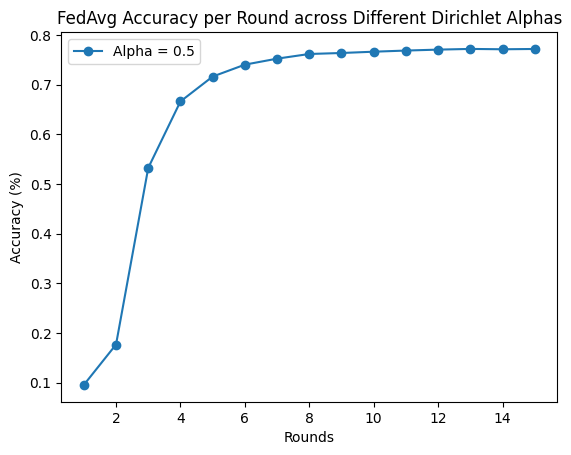

In [81]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')
    # plt.plot(range(1, rounds + 1), accuracies_per_alpha_EUC[idx], marker='.', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()

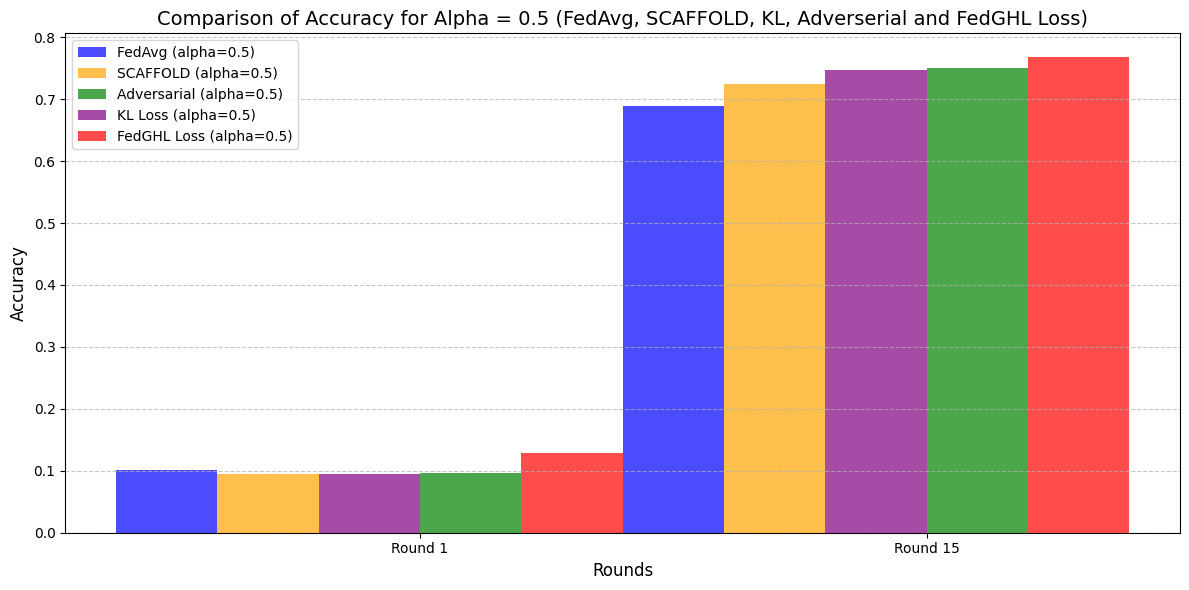

In [44]:
# Fixing the syntax error and ensuring proper data selection

# Data for alpha=0.5
mmd_alpha05 = [0.1598, 0.0952, 0.1981, 0.5015, 0.6316, 0.6764, 0.6935, 0.703, 0.706, 0.7142, 0.715, 0.7165, 0.7203, 0.7202, 0.7183]
fedavg_alpha05 = [0.1016, 0.2805, 0.5640, 0.6546, 0.6661, 0.6809, 0.6878, 0.6888, 0.6908, 0.6850, 0.6916, 0.6895, 0.6910, 0.6947, 0.6895]
scaffold_alpha05 = [0.0951, 0.2149, 0.5747, 0.6814, 0.6951, 0.7037, 0.7143, 0.7162, 0.7212, 0.7208, 0.7186, 0.7249, 0.7270, 0.7210, 0.7249]
kl_alpha05 = [0.0951, 0.2014, 0.5489, 0.6652, 0.7069, 0.7245, 0.7307, 0.7361, 0.7379, 0.7443, 0.7397, 0.7494, 0.745, 0.7466, 0.7463]
l2_loss = [0.0952, 0.2042, 0.5883, 0.6691, 0.6938, 0.7102, 0.7153, 0.7208, 0.7218, 0.727, 0.7287, 0.7276, 0.7303, 0.7282, 0.7293]
was_loss = [0.0982, 0.3073, 0.5888, 0.6435, 0.6816, 0.6948, 0.7043, 0.7014, 0.7115, 0.7126, 0.7141, 0.7158, 0.7127, 0.7144, 0.7144]
adversarial_loss = [0.0957, 0.2412, 0.5650, 0.6702, 0.7044, 0.7143, 0.7221, 0.7264, 0.7301, 0.7345, 0.7387, 0.7442, 0.7467, 0.7486, 0.7501]
fedghl_loss = [0.129, 0.3542, 0.5464, 0.6564, 0.7104, 0.7337, 0.7454, 0.7548, 0.7573, 0.7621, 0.7647, 0.766, 0.7657, 0.7687, 0.7678]



# Selected rounds (1 and 15)
selected_rounds = [0, 14]  
round_labels = ['Round 1', 'Round 15']

# Filter data for selected rounds
fedavg_alpha05_selected = [fedavg_alpha05[i] for i in selected_rounds]
scaffold_alpha05_selected = [scaffold_alpha05[i] for i in selected_rounds]
mmd_alpha05_selected = [adversarial_loss[i] for i in selected_rounds]
kl_alpha05_selected = [kl_alpha05[i] for i in selected_rounds]
fedghlloss_05 = [fedghl_loss[i] for i in selected_rounds]

# Bar positions
x = np.arange(len(round_labels))  # X-axis positions
bar_width = 0.2

# Plot
plt.figure(figsize=(12, 6))

# Bars
plt.bar(x - 2.5 * bar_width, fedavg_alpha05_selected, width=bar_width, label='FedAvg (alpha=0.5)', color='blue', alpha=0.7)
plt.bar(x - 1.5 * bar_width, scaffold_alpha05_selected, width=bar_width, label='SCAFFOLD (alpha=0.5)', color='orange', alpha=0.7)
plt.bar(x + 0.5 * bar_width, mmd_alpha05_selected, width=bar_width, label='Adversarial (alpha=0.5)', color='green', alpha=0.7)
plt.bar(x - 0.5 * bar_width, kl_alpha05_selected, width=bar_width, label='KL Loss (alpha=0.5)', color='purple', alpha=0.7)
plt.bar(x + 1.5 * bar_width, fedghlloss_05, width=bar_width, label='FedGHL Loss (alpha=0.5)', color='red', alpha=0.7)
# Labels and legend
plt.xlabel('Rounds', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Accuracy for Alpha = 0.5 (FedAvg, SCAFFOLD, KL, Adverserial and FedGHL Loss)', fontsize=14)
plt.xticks(x, round_labels, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [31]:
def visualize_gradients(grad_ce, grad_align, grad_ce_h, grad_align_h):
    """
    Visualize gradient vectors before and after harmonization in 2D.

    Args:
        grad_ce: Original gradient vector for classification loss.
        grad_align: Original gradient vector for alignment loss.
        grad_ce_h: Harmonized gradient vector for classification loss.
        grad_align_h: Harmonized gradient vector for alignment loss.
    """
    # Normalize gradients for visualization
    grad_ce = grad_ce / torch.norm(grad_ce)
    grad_align = grad_align / torch.norm(grad_align)
    grad_ce_h = grad_ce_h / torch.norm(grad_ce_h)
    grad_align_h = grad_align_h / torch.norm(grad_align_h)

    # Prepare vectors for plotting
    vectors = {
        "Original CE": (0, 0, grad_ce[0].item(), grad_ce[1].item()),
        "Original Align": (0, 0, grad_align[0].item(), grad_align[1].item()),
        "Harmonized CE": (0, 0, grad_ce_h[0].item(), grad_ce_h[1].item()),
        "Harmonized Align": (0, 0, grad_align_h[0].item(), grad_align_h[1].item()),
    }

    # Plot original and harmonized gradients
    plt.figure(figsize=(8, 8))
    for label, (x, y, dx, dy) in vectors.items():
        plt.arrow(x, y, dx, dy, head_width=0.05, length_includes_head=True, label=label)

    # Annotations and formatting
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xlabel("Gradient Dimension 1")
    plt.ylabel("Gradient Dimension 2")
    plt.title("Gradient Vectors Before and After Harmonization")
    plt.legend()
    plt.grid(True)
    plt.show()




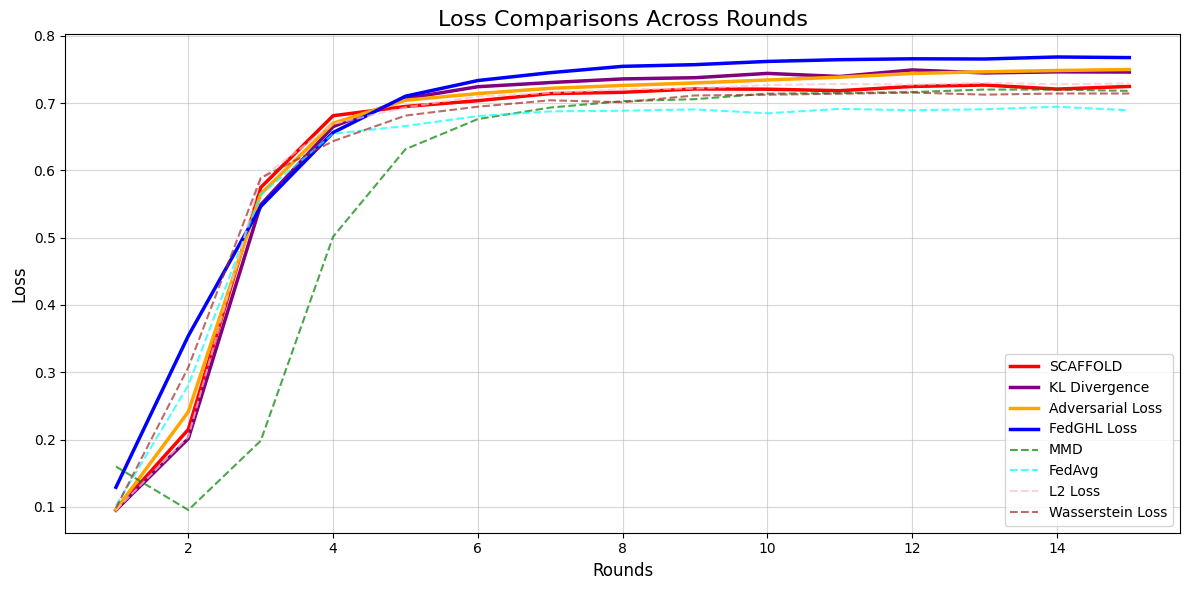

In [48]:
# Data
rounds = list(range(1, 16))
mmd_alpha05 = [0.1598, 0.0952, 0.1981, 0.5015, 0.6316, 0.6764, 0.6935, 0.703, 0.706, 0.7142, 0.715, 0.7165, 0.7203, 0.7202, 0.7183]
fedavg_alpha05 = [0.1016, 0.2805, 0.5640, 0.6546, 0.6661, 0.6809, 0.6878, 0.6888, 0.6908, 0.6850, 0.6916, 0.6895, 0.6910, 0.6947, 0.6895]
scaffold_alpha05 = [0.0951, 0.2149, 0.5747, 0.6814, 0.6951, 0.7037, 0.7143, 0.7162, 0.7212, 0.7208, 0.7186, 0.7249, 0.7270, 0.7210, 0.7249]
kl_alpha05 = [0.0951, 0.2014, 0.5489, 0.6652, 0.7069, 0.7245, 0.7307, 0.7361, 0.7379, 0.7443, 0.7397, 0.7494, 0.745, 0.7466, 0.7463]
l2_loss = [0.0952, 0.2042, 0.5883, 0.6691, 0.6938, 0.7102, 0.7153, 0.7208, 0.7218, 0.727, 0.7287, 0.7276, 0.7303, 0.7282, 0.7293]
was_loss = [0.0982, 0.3073, 0.5888, 0.6435, 0.6816, 0.6948, 0.7043, 0.7014, 0.7115, 0.7126, 0.7141, 0.7158, 0.7127, 0.7144, 0.7144]
adversarial_loss = [0.0957, 0.2412, 0.5650, 0.6702, 0.7044, 0.7143, 0.7221, 0.7264, 0.7301, 0.7345, 0.7387, 0.7442, 0.7467, 0.7486, 0.7501]
fedghl_loss = [0.129, 0.3542, 0.5464, 0.6564, 0.7104, 0.7337, 0.7454, 0.7548, 0.7573, 0.7621, 0.7647, 0.766, 0.7657, 0.7687, 0.7678]

# Plot
plt.figure(figsize=(12, 6))

# Prominent lines
plt.plot(rounds, scaffold_alpha05, label='SCAFFOLD', color='red', linewidth=2.5)
plt.plot(rounds, kl_alpha05, label='KL Divergence', color='purple', linewidth=2.5)
plt.plot(rounds, adversarial_loss, label='Adversarial Loss', color='orange', linewidth=2.5)
plt.plot(rounds, fedghl_loss, label='FedGHL Loss', color='blue', linewidth=2.5)

# Other lines
plt.plot(rounds, mmd_alpha05, label='MMD', color='green', linestyle='--', alpha=0.7)
plt.plot(rounds, fedavg_alpha05, label='FedAvg', color='cyan', linestyle='--', alpha=0.7)
plt.plot(rounds, l2_loss, label='L2 Loss', color='pink', linestyle='--', alpha=0.7)
plt.plot(rounds, was_loss, label='Wasserstein Loss', color='brown', linestyle='--', alpha=0.7)

# Labels and legend
plt.xlabel('Rounds', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Comparisons Across Rounds', fontsize=16)
plt.legend(fontsize=10, loc='lower right')
plt.grid(alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()
